In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)
library(DESeq2)

## Preprocessing

In [24]:
setwd("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/")

biom <- import_biom("all_cohorts_cadaver_deblur.biom")
map <- import_qiime_sample_data("all_cadaver_metadata.txt")
tree <- read_tree("rep_phylo.tre")
cadaver_nt <- merge_phyloseq(biom,tree,map)
cadaver_nt <- prune_samples(sample_sums(cadaver_nt) > 1000, cadaver_nt)
cadaver <- merge_phyloseq(biom,tree,map) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))

saveRDS(cadaver_nt, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver_nt.rds")
saveRDS(cadaver, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver.rds")
                                                      

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [3]:
cadaver_nt = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver_nt.rds")
cadaver = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver.rds")


In [12]:
count(sample_tab, vars=Organ)

vars,n
Blood,7
Brain,50
Heart,53
Liver,109
Mouth Swab,13
Prostate,25
Spleen,38
Uterus,15


In [13]:
Brain = subset_samples(cadaver_nt, Organ=="Brain")
Heart = subset_samples(cadaver_nt, Organ=="Heart")
Liver = subset_samples(cadaver_nt, Organ=="Liver")
Prostate = subset_samples(cadaver_nt, Organ=="Prostate")
Uterus = subset_samples(cadaver_nt, Organ=="Uterus")
Spleen = subset_samples(cadaver_nt, Organ=="Spleen")

In [14]:
Brain = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Brain_nt.rds")
Heart = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Heart_nt.rds")
Liver = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Liver_nt.rds")
Prostate = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Prostate_nt.rds")
Uterus = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Uterus_nt.rds")
Spleen = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Spleen_nt.rds")

In [20]:
brain_otu = otu_table(Brain)
heart_otu = otu_table(Heart)
liver_otu = otu_table(Liver)
prostate_otu = otu_table(Prostate)
uterus_otu = otu_table(Uterus)
spleen_otu = otu_table(Spleen)

write.table(brain_otu, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/brain_otu.txt", sep="\t")
write.table(heart_otu, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/heart_otu.txt", sep="\t")
write.table(liver_otu, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/liver_otu.txt", sep="\t")
write.table(prostate_otu, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/prostate_otu.txt", sep="\t")
write.table(uterus_otu, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/uterus_otu.txt", sep="\t")
write.table(spleen_otu, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/spleen_otu.txt", sep="\t")

In [23]:
library(microbiomeSeq)

### Alpha Diversity Measures

##### Shannon Diversity Calculations

In [5]:
sample_tab = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/all_cadaver_metadata.csv")
colnames(sample_tab)[1] <- "SampleID"

In [10]:
sha = estimate_richness(cadaver_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Organ") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Organ")

stats.sha = dfsha %>%
    group_by(Organ) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(mean))
stats.sha

Organ,median,mean,sd,sem
Heart,1.624730,1.429424,0.9792621,0.1548349
Blood,1.859476,1.530832,0.8126412,0.3071495
Spleen,1.834304,1.678410,1.0405528,0.1734255
Liver,1.621973,1.751835,1.2217730,0.1203849
Brain,1.989188,1.825932,0.7555543,0.1139041
Uterus,2.641988,2.700381,0.6858481,0.1902200
Prostate,3.054951,2.794671,1.0881414,0.2374519


In [22]:
#Record Stats
cat("Tests Output", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt")
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
cat("Shannon Div stats\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(stats.sha, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

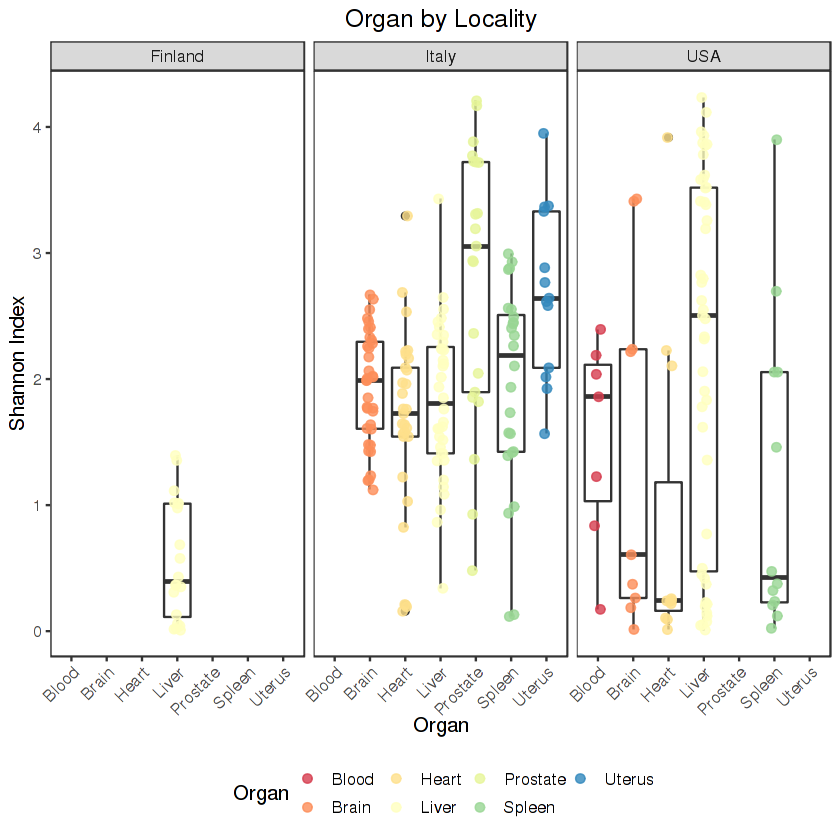

In [39]:
#dfsha$The.manner.of.death <- factor(dfsha$The.manner.of.death, levels=c("Accident", "Natural","Homicide", "Suicide"))

p = ggplot(dfsha, aes(x = Organ, y = Shannon)) + ggtitle("Organ by Locality")

p = p + geom_boxplot() + ylab("Shannon Index")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,1200))

p = p + geom_point(size = 2,alpha=.8, aes(color = Organ),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
                           

p = p + facet_wrap(~Location)

p

In [19]:
krusk = kruskal.test(Shannon ~ The_manner_of_death, data=dfsha) 
krusk


	Kruskal-Wallis rank sum test

data:  Shannon by The_manner_of_death
Kruskal-Wallis chi-squared = 59.814, df = 8, p-value = 5.07e-10


In [21]:
library(dunn.test)
dunn = dunn.test(dfsha$Shannon, g=dfsha$The_manner_of_death, method="BH")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 59.8137, df = 8, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Accident   Accident   Accident   Accident   Homicide    Natural
---------+------------------------------------------------------------------
Accident |  -0.219207
         |     0.4649
         |
Accident |  -2.706723  -1.365774
         |    0.0175*     0.1548
         |
Accident |  -1.613280  -1.144665  -0.162545
         |     0.1200     0.2065     0.4611
         |
Homicide |  -3.550184  -1.690376  -0.395019  -0.066482
         |    0.0012*     0.1259     0.4023     0.4870
         |
 Natural |   2.639950   1.421426   4.425936   2.598502   5.397581
         |    0.0166*     0.1470    0.0000*    0.0169*    0.0000*
         |
Natural  |  -2.551469  -0.853202   1.039203   0.726008   1.684446  -4.

$chi2
[1] 59.81369

$Z
 [1] -0.21920719 -2.70672321 -1.36577477 -1.61328065 -1.14466596 -0.16254532
 [7] -3.55018479 -1.69037620 -0.39501995 -0.06648298  2.63995050  1.42142661
[13]  4.42593621  2.59850212  5.39758181 -2.55146906 -0.85320285  1.03920306
[19]  0.72600810  1.68444676 -4.97440324 -3.76596096 -1.48696512  0.00805831
[25]  0.17752513  0.50186995 -5.93519235 -1.44342167 -1.99253632 -1.63877970
[31] -0.92236432 -0.69187269 -0.76391157 -2.70612925 -1.35543259 -0.95731467

$P
 [1] 4.132443e-01 3.397544e-03 8.600483e-02 5.334177e-02 1.261738e-01
 [6] 4.354382e-01 1.924804e-04 4.547800e-02 3.464141e-01 4.734967e-01
[11] 4.145907e-03 7.759639e-02 4.801245e-06 4.681573e-03 3.377254e-08
[16] 5.363492e-03 1.967734e-01 1.493552e-01 2.339169e-01 4.604768e-02
[21] 3.272447e-07 8.295486e-05 6.851201e-02 4.967852e-01 4.295480e-01
[26] 3.078795e-01 1.467506e-09 7.445086e-02 2.315612e-02 5.062957e-02
[31] 1.781693e-01 2.445086e-01 2.224600e-01 3.403627e-03 8.763989e-02
[36] 1.692042e-01

$P.adjusted
 [1] 4.648999e-01 1.747308e-02 1.548087e-01 1.200190e-01 2.064662e-01
 [6] 4.610522e-01 1.154883e-03 1.259391e-01 4.022873e-01 4.870251e-01
[11] 1.658363e-02 1.470247e-01 4.321120e-05 1.685366e-02 6.079057e-07
[16] 1.755325e-02 2.724555e-01 2.337733e-01 3.007503e-01 1.184083e-01
[21] 3.926937e-06 5.972750e-04 1.450843e-01 4.967852e-01 4.685978e-01
[26] 3.694554e-01 5.283022e-08 1.489017e-01 6.946837e-02 1.215110e-01
[31] 2.565638e-01 3.035280e-01 2.966133e-01 1.531632e-02 1.502398e-01
[36] 2.538063e-01

$comparisons
 [1] "Accident - Accident_road traffic accident"                      
 [2] "Accident - Accident_Road traffic accident"                      
 [3] "Accident_road traffic accident - Accident_Road traffic accident"
 [4] "Accident - Accident_Work related accident"                      
 [5] "Accident_road traffic accident - Accident_Work related accident"
 [6] "Accident_Road traffic accident - Accident_Work related accident"
 [7] "Accident - Homicide"                                            
 [8] "Accident_road traffic accident - Homicide"                      
 [9] "Accident_Road traffic accident - Homicide"                      
[10] "Accident_Work related accident - Homicide"                      
[11] "Accident - Natural"                                             
[12] "Accident_road traffic accident - Natural"                       
[13] "Accident_Road traffic accident - Natural"                       
[14] "Accident_Work related accident - Natural"                       
[15] "Homicide - Natural"                                             
[16] "Accident - Natural death"                                       
[17] "Accident_road traffic accident - Natural death"                 
[18] "Accident_Road traffic accident - Natural death"                 
[19] "Accident_Work related accident - Natural death"                 
[20] "Homicide - Natural death"                                       
[21] "Natural - Natural death"                                        
[22] "Accident - Suicide"                                             
[23] "Accident_road traffic accident - Suicide"                       
[24] "Accident_Road traffic accident - Suicide"                       
[25] "Accident_Work related accident - Suicide"                       
[26] "Homicide - Suicide"                                             
[27] "Natural - Suicide"                                              
[28] "Natural death - Suicide"                                        
[29] "Accident - Undetermined"                                        
[30] "Accident_road traffic accident - Undetermined"                  
[31] "Accident_Road traffic accident - Undetermined"                  
[32] "Accident_Work related accident - Undetermined"                  
[33] "Homicide - Undetermined"                                        
[34] "Natural - Undetermined"                                         
[35] "Natural death - Undetermined"                   

In [23]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export kruskal-wallis
cat("Shannon Div Krsukal-Wallis\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(krusk, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# add 2 newlines
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export dunn.test
cat("Shannon Div Dunn Test\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(dunn, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

### Observed Diversity Calculations

In [24]:
obs = estimate_richness(cadaver_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

In [26]:
#Export to local to remove "X"'s in front of SampleID, reimport and continue - try setting as.factor next time
#write.csv(obs, "/group/gilbert-lab/Lutz/Cadaver/temp_obs.csv")
obs = read.csv("/group/gilbert-lab/Lutz/Cadaver/temp_obs.csv")

In [29]:
dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("The_manner_of_death") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("The_manner_of_death")

stats.obs = dfobs %>%
    group_by(The_manner_of_death) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(mean))
stats.obs

The_manner_of_death,median,mean,sd,sem
Accident_Work related accident,32.5,46.00000,33.21646,16.608231
Accident_road traffic accident,38.5,47.66667,32.27796,13.177422
Natural,34.0,52.72093,48.53292,7.401201
Accident_Road traffic accident,48.0,55.11765,35.78212,8.678439
Accident,33.0,55.57377,52.87106,6.769445
Natural death,43.0,55.96825,36.28292,4.571219
Suicide,45.0,71.08889,53.05436,7.908876
Homicide,54.0,86.91304,62.67515,13.068671
Undetermined,247.0,247.00000,144.24978,102.000000


In [30]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
cat("Obs Richness stats\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(stats.obs, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)


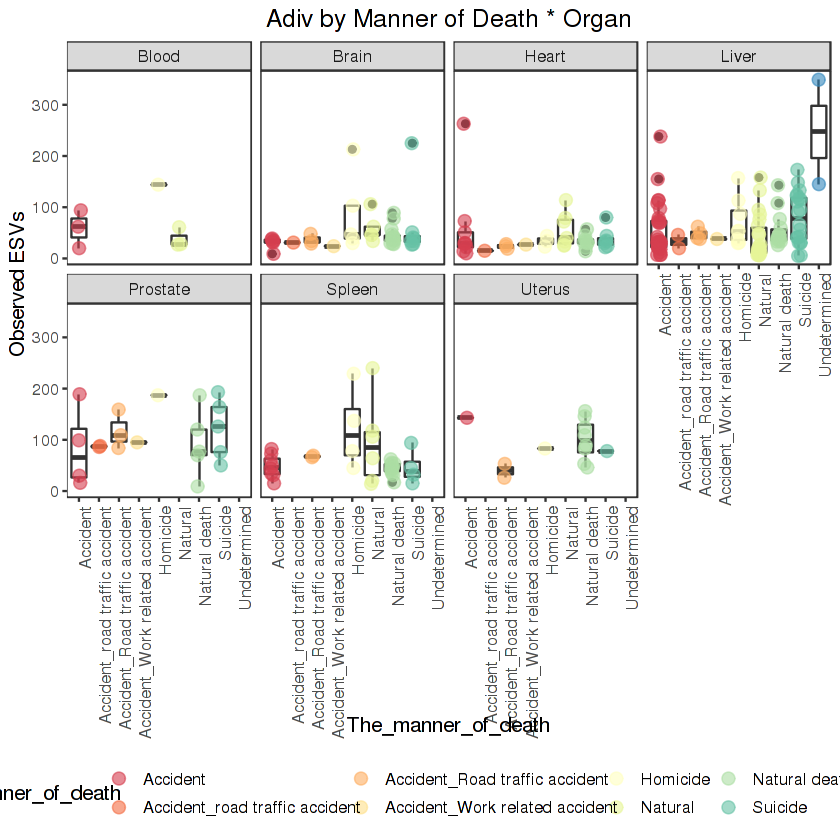

In [41]:
#dfobs$The_manner_of_death <- factor(dfobs$The_manner_of_death, levels=c("Accident", "Natural","Homicide", "Suicide"))

p = ggplot(dfobs, aes(x = The_manner_of_death, y = Observed)) + ggtitle("Adiv by Manner of Death * Organ")

p = p + geom_boxplot() + ylab("Observed ESVs")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,1200))

p = p + geom_point(size = 3,alpha=.6, aes(color = The_manner_of_death),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p = p + facet_wrap(~Organ, ncol=4)

p

In [42]:
krusk = kruskal.test(Observed ~ The_manner_of_death, data=dfobs) 
krusk


	Kruskal-Wallis rank sum test

data:  Observed by The_manner_of_death
Kruskal-Wallis chi-squared = 19.782, df = 8, p-value = 0.01119


In [45]:
library(dunn.test)
dunn = dunn.test(dfobs$Observed, g=dfobs$The_manner_of_death, method="BH")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 19.7822, df = 8, p-value = 0.01


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Accident   Accident   Accident   Accident   Homicide    Natural
---------+------------------------------------------------------------------
Accident |   0.008824
         |     0.4965
         |
Accident |  -0.855505  -0.502053
         |     0.3070     0.3821
         |
Accident |   0.217741   0.168254   0.624438
         |     0.4655     0.4726     0.3422
         |
Homicide |  -2.894853  -1.553411  -1.481035  -1.514973
         |     0.0341     0.1444     0.1386     0.1460
         |
 Natural |   0.228415   0.095701   0.977717  -0.127981   2.918038
         |     0.4916     0.4751     0.2685     0.4755     0.0634
         |
Natural  |  -1.651788  -0.703303  -0.227143  -0.793384   1.689607  

$chi2
[1] 19.7822

$Z
 [1]  0.008824573 -0.855505930 -0.502053664  0.217741176  0.168254484
 [6]  0.624438043 -2.894853039 -1.553411992 -1.481035891 -1.514973510
[11]  0.228415935  0.095701527  0.977717334 -0.127981679  2.918038912
[16] -1.651788372 -0.703303817 -0.227143899 -0.793384740  1.689607710
[21] -1.729896647 -2.219307708 -1.012138128 -0.707745043 -1.051265045
[26]  1.062025563 -2.258300623 -0.714236562 -2.529897406 -2.231207246
[31] -2.118091680 -2.229011853 -1.505222415 -2.576129451 -2.118069913
[36] -1.912246950

$P
 [1] 0.496479550 0.196135561 0.307814886 0.413815390 0.433191540 0.266169974
 [7] 0.001896680 0.060162370 0.069298505 0.064889556 0.409661451 0.461878814
[13] 0.164107073 0.449081736 0.001761202 0.049288850 0.240933216 0.410155925
[19] 0.213776849 0.045551515 0.041824371 0.013232899 0.155736007 0.239551800
[25] 0.146568438 0.144112040 0.011963462 0.237540456 0.005704794 0.012833702
[31] 0.017083652 0.012906558 0.066133452 0.004995662 0.017084574 0.027922263

$P.adjusted
 [1] 0.49647955 0.30699479 0.38211503 0.46554231 0.47257259 0.34221854
 [7] 0.03414025 0.14438969 0.13859701 0.14600150 0.49159374 0.47507535
[13] 0.26853885 0.47549831 0.06340327 0.12674276 0.32124429 0.47631011
[19] 0.32066527 0.12614266 0.12547311 0.05954804 0.26697601 0.33168711
[25] 0.26382319 0.27305439 0.08613692 0.34205826 0.05134315 0.07700221
[31] 0.06833461 0.06637658 0.14004731 0.05994794 0.06150446 0.09138195

$comparisons
 [1] "Accident - Accident_road traffic accident"                      
 [2] "Accident - Accident_Road traffic accident"                      
 [3] "Accident_road traffic accident - Accident_Road traffic accident"
 [4] "Accident - Accident_Work related accident"                      
 [5] "Accident_road traffic accident - Accident_Work related accident"
 [6] "Accident_Road traffic accident - Accident_Work related accident"
 [7] "Accident - Homicide"                                            
 [8] "Accident_road traffic accident - Homicide"                      
 [9] "Accident_Road traffic accident - Homicide"                      
[10] "Accident_Work related accident - Homicide"                      
[11] "Accident - Natural"                                             
[12] "Accident_road traffic accident - Natural"                       
[13] "Accident_Road traffic accident - Natural"                       
[14] "Accident_Work related accident - Natural"                       
[15] "Homicide - Natural"                                             
[16] "Accident - Natural death"                                       
[17] "Accident_road traffic accident - Natural death"                 
[18] "Accident_Road traffic accident - Natural death"                 
[19] "Accident_Work related accident - Natural death"                 
[20] "Homicide - Natural death"                                       
[21] "Natural - Natural death"                                        
[22] "Accident - Suicide"                                             
[23] "Accident_road traffic accident - Suicide"                       
[24] "Accident_Road traffic accident - Suicide"                       
[25] "Accident_Work related accident - Suicide"                       
[26] "Homicide - Suicide"                                             
[27] "Natural - Suicide"                                              
[28] "Natural death - Suicide"                                        
[29] "Accident - Undetermined"                                        
[30] "Accident_road traffic accident - Undetermined"                  
[31] "Accident_Road traffic accident - Undetermined"                  
[32] "Accident_Work related accident - Undetermined"                  
[33] "Homicide - Undetermined"                                        
[34] "Natural - Undetermined"                                         
[35] "Natural death - Undetermined"                                   
[36] "Suicide - Undetermined"

In [46]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export kruskal-wallis
cat("Observed Richness Krsukal-Wallis\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(krusk, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# add 2 newlines
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export dunn.test
cat("Observed Richness Dunn Test\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(dunn, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

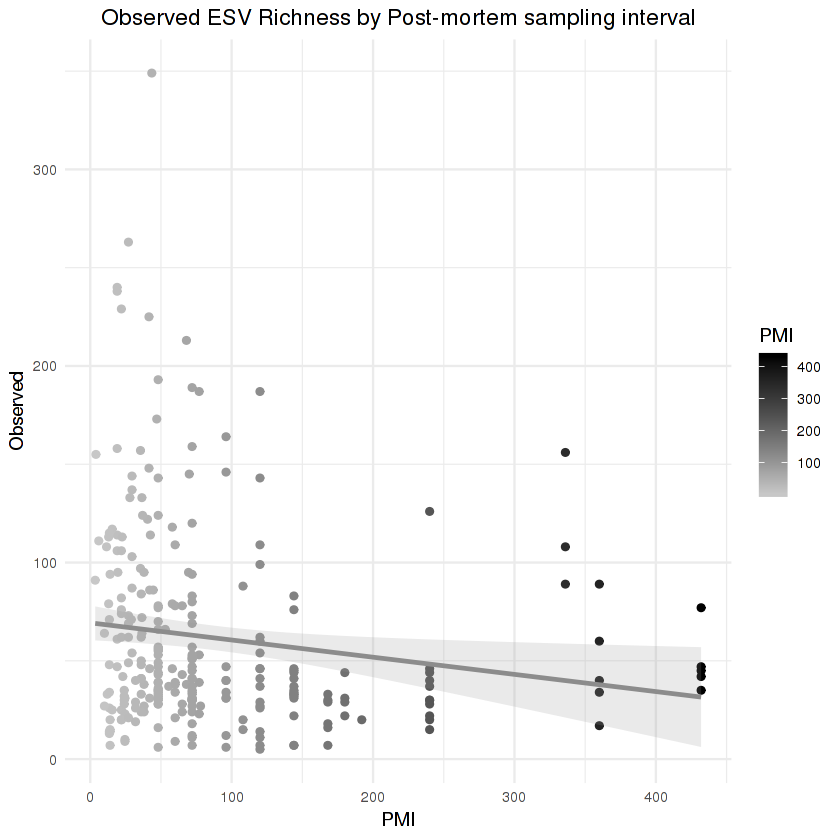

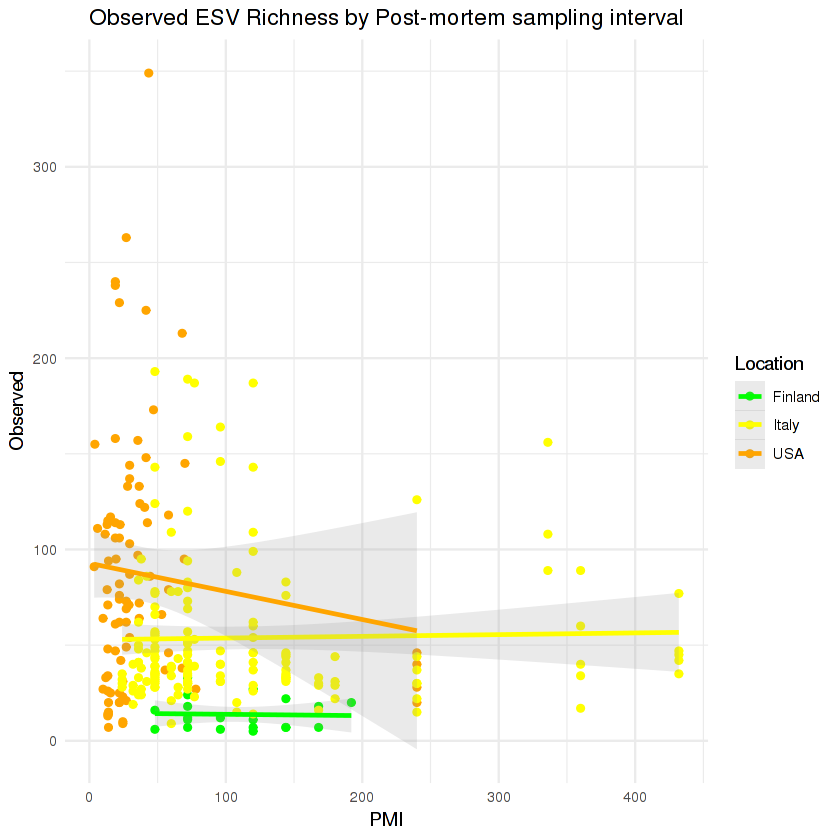

In [48]:
p1 = ggplot(dfobs, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p1 = p1 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p1 = p1 + scale_colour_gradient(low = "grey78", high = "black")
p1

p2 = ggplot(dfobs, aes(x=PMI, y=Observed, colour = Location)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval")
p2 = p2 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p2 = p2 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p2 = p2 + scale_colour_manual(values = c("Green", "Yellow", "Orange"))
p2

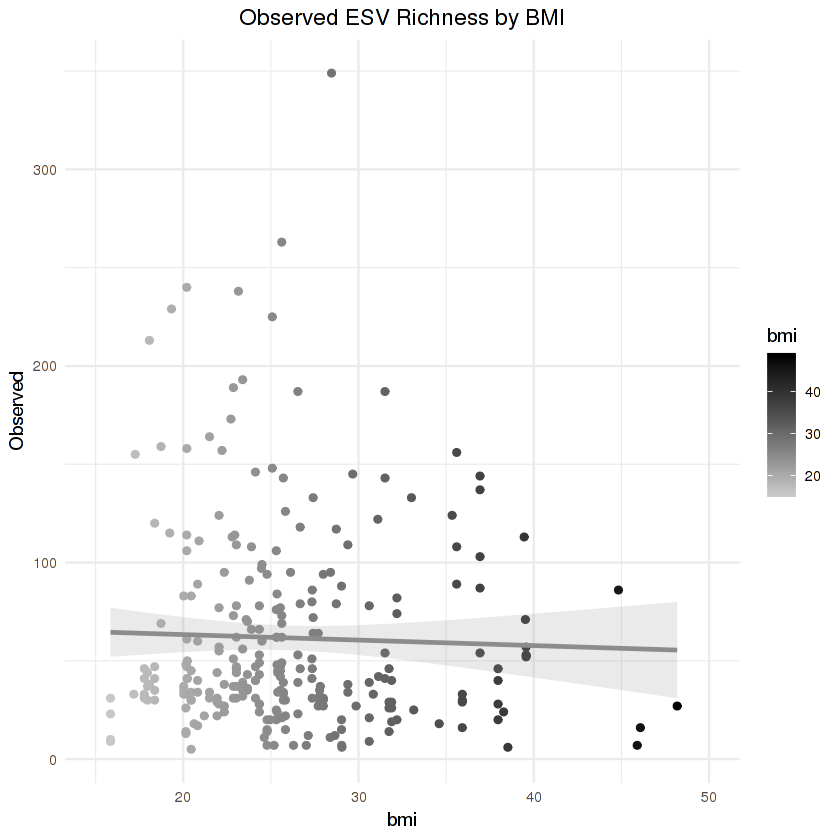

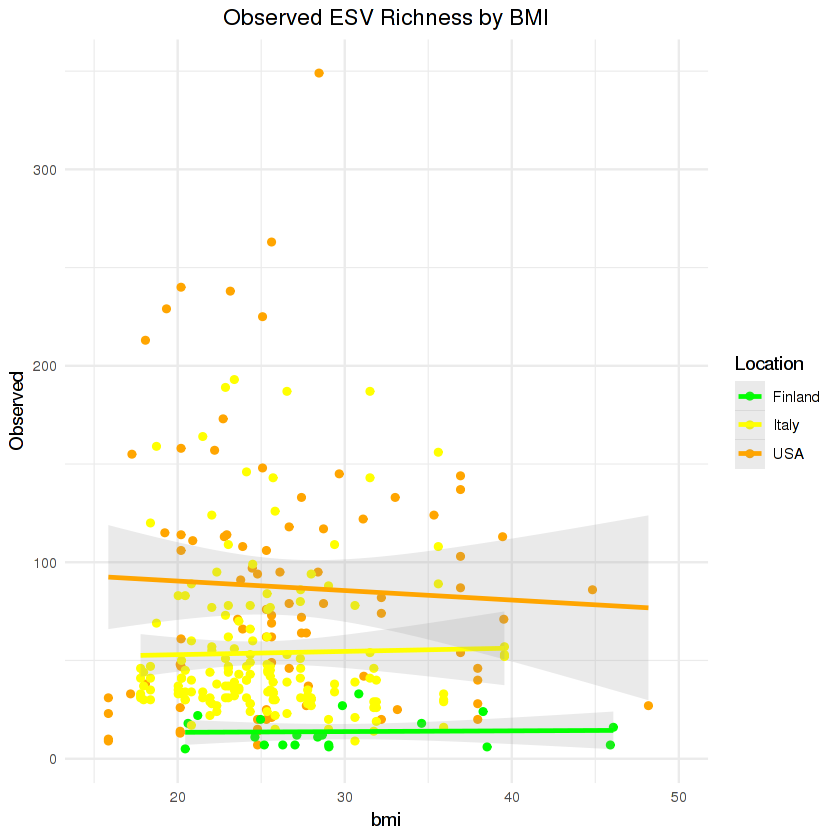

In [52]:
p3 = ggplot(dfobs, aes(x=bmi, y=Observed, colour = bmi)) + geom_point() + ggtitle("Observed ESV Richness by BMI")
p3 = p3 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") +
         theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) +
         scale_colour_gradient(low = "grey78", high = "black") +
         xlim(c(15,50))
p3

p4 = ggplot(dfobs, aes(x=bmi, y=Observed, colour = Location)) + geom_point() +  ggtitle("Observed ESV Richness by BMI")
p4 = p4 + geom_smooth(method = "lm", se=TRUE, alpha=.2) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) +
        scale_colour_manual(values = c("Green", "Yellow", "Orange")) +
        xlim(c(15,50))
p4

In [54]:
#SUMMARIZE REGRESSION COEFFICIENTS - Break down by sample type before running
fit <- lm(bmi ~ Observed, data = dfobs)
summary(fit)

In [81]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
cat("Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

In [68]:
dfobs.fin = dfobs[which(dfobs$Location=='Finland'),]
dfobs.ita = dfobs[which(dfobs$Location=='Italy'),]
dfobs.usa = dfobs[which(dfobs$Location=='USA'),]

In [71]:
head(dfobs.fin)

,SampleID,X,Observed,BarcodeSequence,LinkerPrimerSequence,RTL_run,Case_no,Sex,Age,Ethnicity,...,Organ,RTLID,Samplename,Cause_of_death,The_manner_of_death,Height_cm,Weight_kg,bmi,bmi_category,Description
87,4885.12Liver,4885.12Liver,7,AAAACAAA,GTGCCAGCMGCCGCGGTAA,4885,L549,M,56,C,...,Liver,12,12-MS515F,Phlebitis and thrombophlebitis,Natural,171,79,27.02,overweight,4885.12_Liver
88,4885.15Liver,4885.15Liver,6,AAAACAAC,GTGCCAGCMGCCGCGGTAA,4885,L558,M,64,C,...,Liver,15,15-MS515F,Hypertensive heart disease without congestive heart failure,Natural,183,129,38.52,obese,4885.15_Liver
89,4885.16Liver,4885.16Liver,22,AAAACAAG,GTGCCAGCMGCCGCGGTAA,4885,L568,M,55,C,...,Liver,16,16-MS515F,Accidental poisoning by and exposure to alcohol,Accident,171,62,21.20,normal,4885.16_Liver
90,4885.19Liver,4885.19Liver,7,AAAACAAT,GTGCCAGCMGCCGCGGTAA,4885,L572,M,75,C,...,Liver,19,19-MS515F,Atherosclerotic heart disease,Natural,176,78,25.18,overweight,4885.19_Liver
91,4885.26Liver,4885.26Liver,18,AAAACACA,GTGCCAGCMGCCGCGGTAA,4885,L584,M,68,C,...,Liver,26,26-MS515F,Duodenal ulcer,Natural,172,61,20.62,normal,4885.26_Liver
92,4885.34Liver,4885.34Liver,24,AAAACACC,GTGCCAGCMGCCGCGGTAA,4885,L603,M,59,C,...,Liver,34,34-MS515F,Alcoholic cardiomyopathy,Natural,160,98,38.28,obese,4885.34_Liver


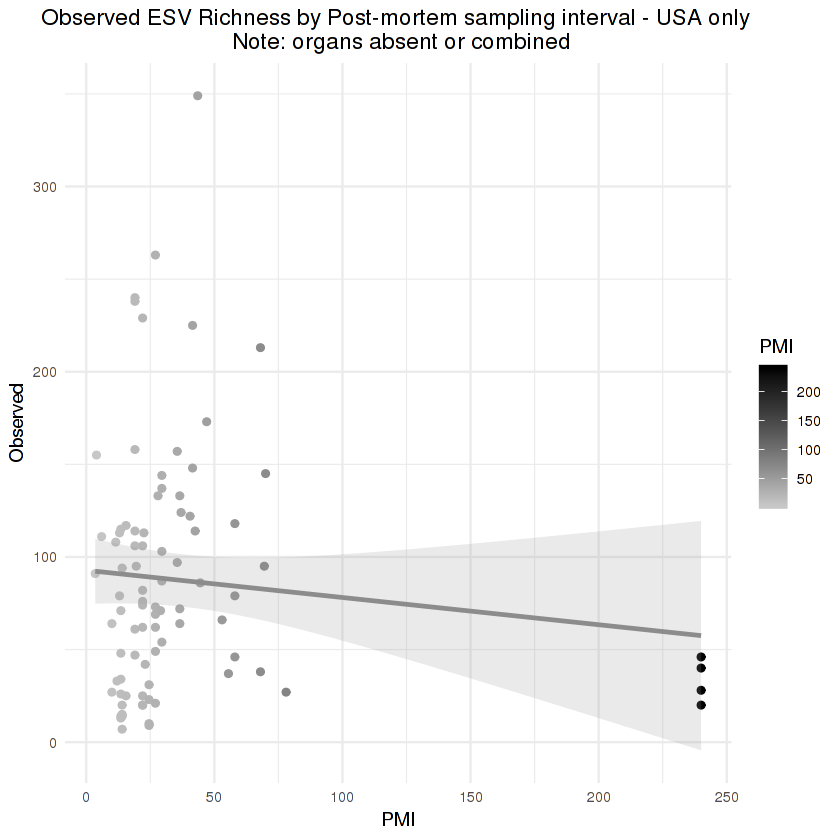

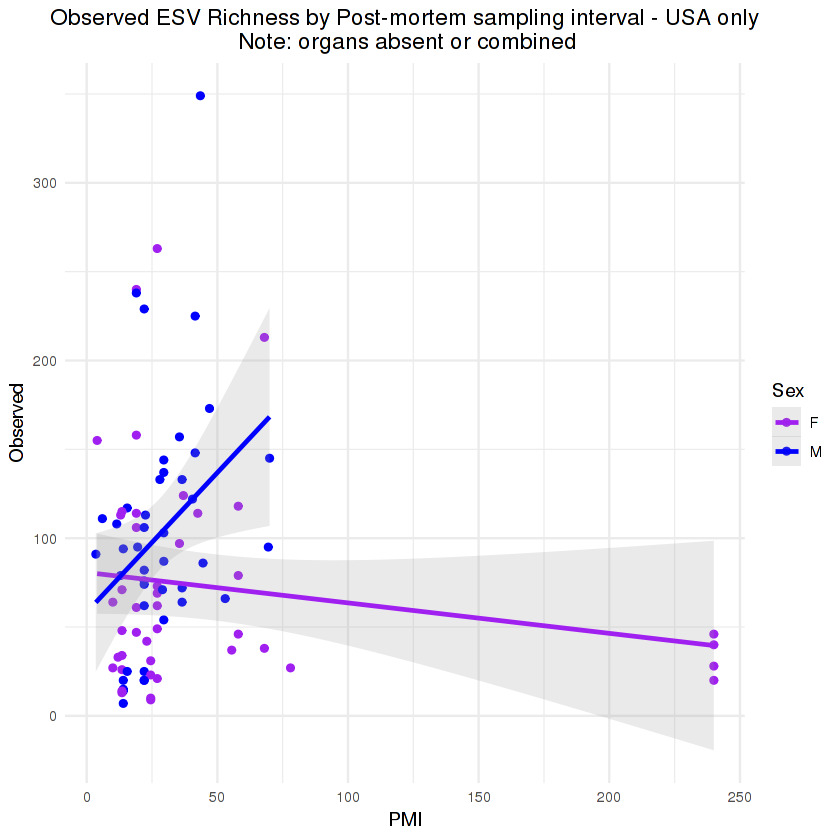

In [63]:
p5 = ggplot(dfobs.usa, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - USA only \n Note: organs absent or combined")
p5 = p5 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p5 = p5 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p5 = p5 + scale_colour_gradient(low = "grey78", high = "black")
p5

p6 = ggplot(dfobs.usa, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - USA only\n Note: organs absent or combined")
p6 = p6 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p6 = p6 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p6 = p6 + scale_colour_manual(values = c("Purple", "Blue"))
p6

In [57]:
fit <- lm(PMI ~ Observed, data = dfobs.usa)
summary(fit)


Call:
lm(formula = PMI ~ Observed, data = dfobs.usa)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.043 -22.129 -13.581   2.946 198.997 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 44.54053    8.56735   5.199 1.39e-06 ***
Observed    -0.07690    0.07847  -0.980     0.33    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.77 on 84 degrees of freedom
Multiple R-squared:  0.01131,	Adjusted R-squared:  -0.0004651 
F-statistic: 0.9605 on 1 and 84 DF,  p-value: 0.3299


In [21]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("USA only - Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

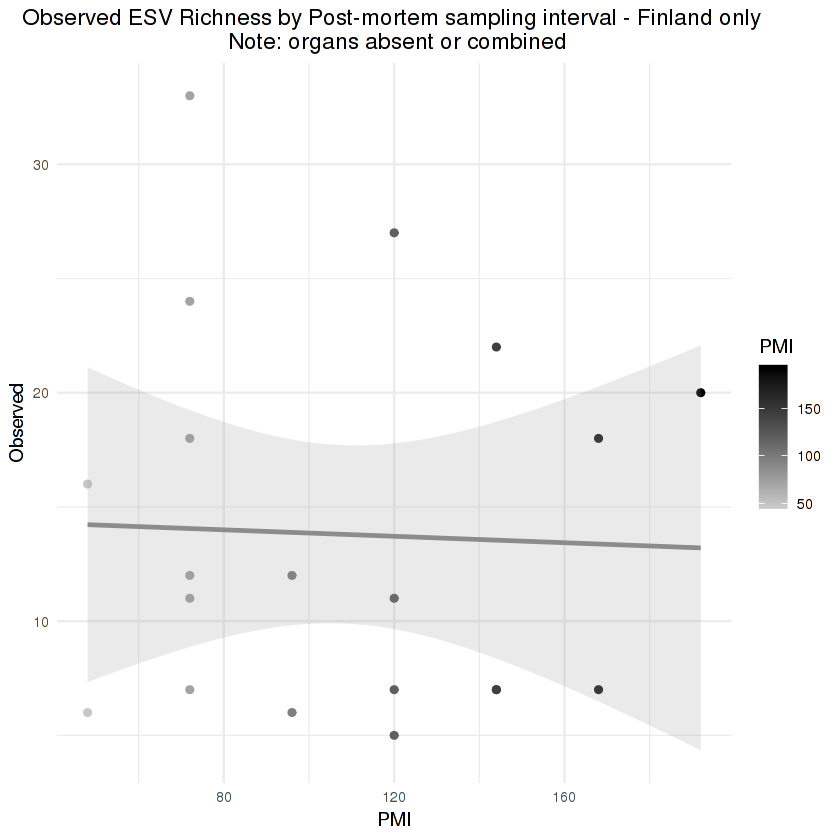

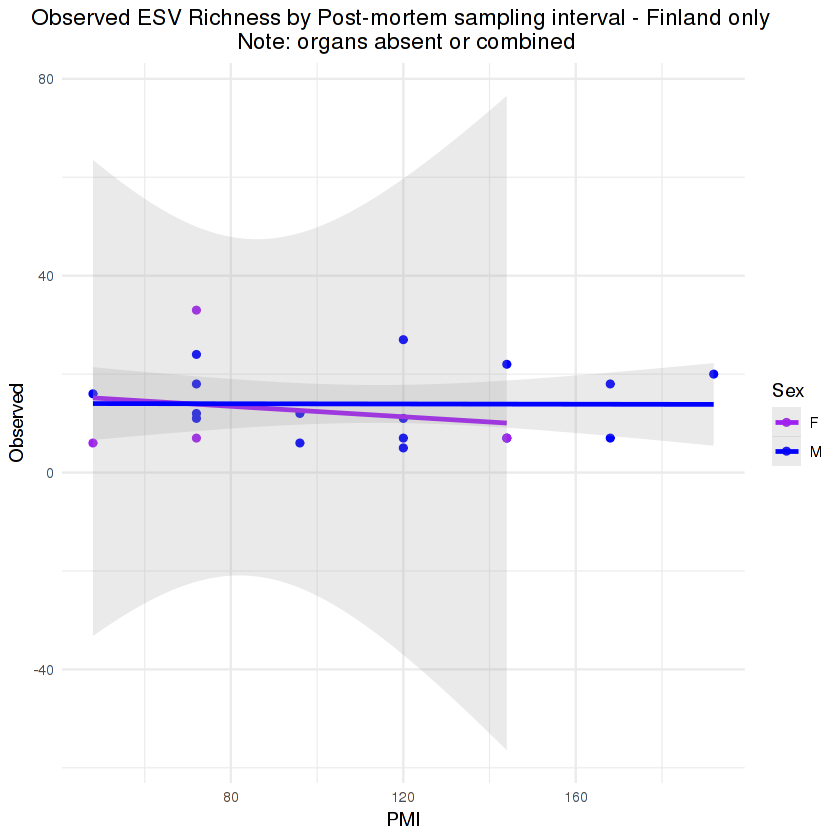

In [72]:
p7 = ggplot(dfobs.fin, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Finland only \n Note: organs absent or combined")
p7 = p7 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p7 = p7 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p7 = p7 + scale_colour_gradient(low = "grey78", high = "black")
p7

p8 = ggplot(dfobs.fin, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Finland only \n Note: organs absent or combined")
p8 = p8 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p8 = p8 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p8 = p8 + scale_colour_manual(values = c("Purple", "Blue"))
p8

In [22]:
fit <- lm(PMI ~ Observed, data = dfobs.fin)
summary(fit)


Call:
lm(formula = PMI ~ Observed, data = dfobs.fin)

Residuals:
   Min     1Q Median     3Q    Max 
-59.81 -34.42 -10.62  36.58  86.58 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 108.8128    19.0398   5.715 1.65e-05 ***
Observed     -0.1995     1.3077  -0.153     0.88    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43.03 on 19 degrees of freedom
Multiple R-squared:  0.001224,	Adjusted R-squared:  -0.05134 
F-statistic: 0.02328 on 1 and 19 DF,  p-value: 0.8803


In [23]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("Finland only - Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

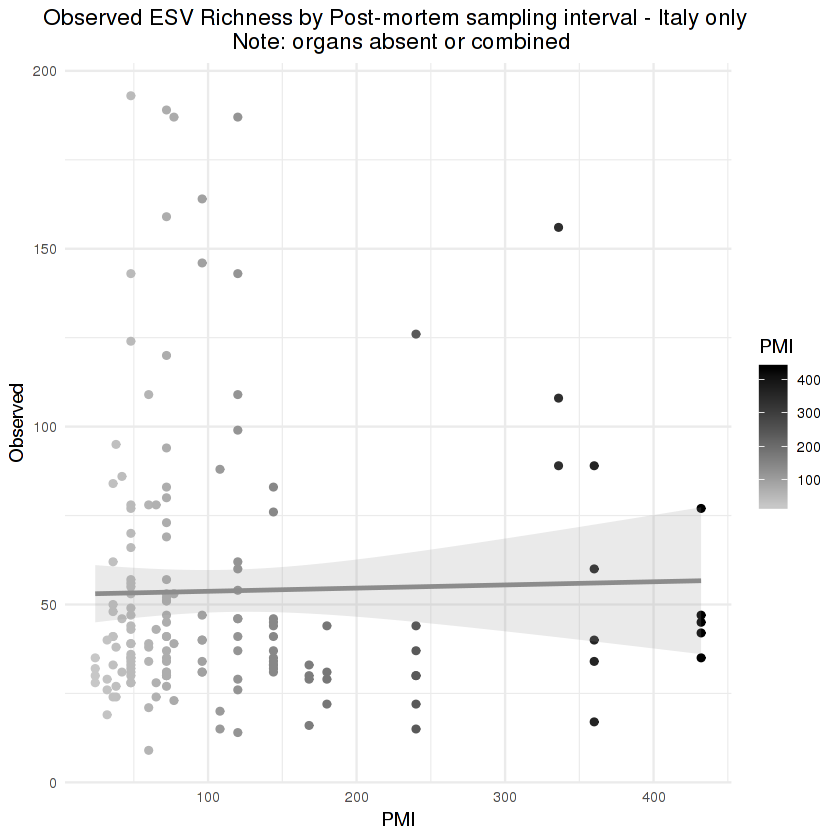

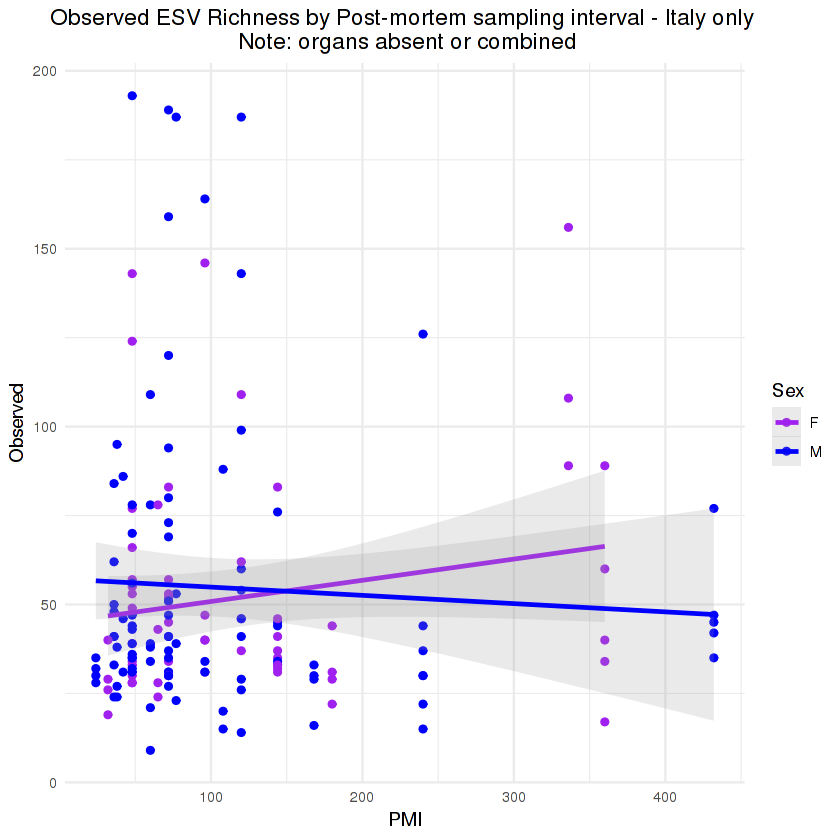

In [69]:
p9 = ggplot(dfobs.ita, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Italy only \n Note: organs absent or combined")
p9 = p9 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p9 = p9 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p9 = p9 + scale_colour_gradient(low = "grey78", high = "black")
p9

p10 = ggplot(dfobs.ita, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Italy only \n Note: organs absent or combined")
p10 = p10 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p10 = p10 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p10 = p10 + scale_colour_manual(values = c("Purple", "Blue"))
p10

## HAVE NOT RUN FOLLOWING BDIV ANALYSES ON ALL COHORTS COMBINED YET

### START HERE:

In [3]:
cadaver_nt_5k = rarefy_even_depth(cadaver_nt, sample.size = 5000,
   replace = FALSE, trimOTUs = TRUE, verbose = TRUE)

cadaver_5k <- cadaver_nt_5k %>%
    transform_sample_counts(function(x) x / sum(x))

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`

...
101 samples removedbecause they contained fewer reads than `sample.size`.
Up to first five removed samples are: 

Case85SpleenCase51LiverCase76BrainCase91SpleenCase69Brain	
...
346OTUs were removed because they are no longer 
present in any sample after random subsampling

...


### Betadiversity

In [4]:
cadaver_5k.df = data.frame(sample_data(cadaver_5k))

In [11]:
# WEIGHTED UNIFRAC (5k rarefied)
cadaver.dist.wunif = distance(cadaver_5k, method = "wunifrac", type = "samples")
cadaver.wunif.nostrata.adtest = adonis2(cadaver.dist.wunif ~ Sex + Ethnicity + Age + Location + The_manner_of_death + PMI + bmi, by = "margin", data=cadaver_5k.df)
cadaver.wunif.nostrata.adtest

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGTAGGGTCCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTGCGCAGGTGGTTGATTAAGTGTGATGTGAAAGCCCCGGGCTCAACCTGGGAATTGCATTGCAAACTGGTCAACTAGAGTATGGCAGAGGGGGGTGGAATTCCGCG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.3964911,0.01214318,2.491210,0.019
Ethnicity,2,0.6097800,0.01867550,1.915667,0.023
Age,1,0.4019787,0.01231125,2.525689,0.013
Location,1,1.7326368,0.05306481,10.886402,0.001
The_manner_of_death,7,2.6169057,0.08014697,2.348913,0.001
PMI,1,0.6627026,0.02029634,4.163854,0.001
bmi,1,0.5332316,0.01633108,3.350369,0.006
Residual,147,23.3959408,0.71653855,NA,NA
Total,162,32.6513358,1.00000000,NA,NA


In [20]:
#bh p-value correction
pval = c("0.019", "0.023", "0.013", "0.001","0.001","0.001","0.006")
cadaver.wunif.nostrata.adtest.padj = p.adjust(pval, method = "BH")
cadaver.wunif.nostrata.adtest.padj

[1] 0.022166667 0.023000000 0.018200000 0.002333333 0.002333333 0.002333333
[7] 0.010500000

In [32]:
# WEIGHTED UNIFRAC (5k rarefied) - Locality set as strata
cadaver.dist.wunif = distance(cadaver_5k, method = "wunifrac", type = "samples")
cadaver.wunif.strata.adtest = adonis2(cadaver.dist.wunif ~ Sex + Ethnicity + Age + The_manner_of_death + PMI + bmi, strata = Location, by = "margin", data=cadaver_5k.df)
cadaver.wunif.strata.adtest

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGTAGGGCGCAAGCATTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTTAACTCCGGATCTGCGGTGGGTACGGGCAGACTTGAGTGATGTAGGGGAGACTGGAATTCCTGG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.1530459,0.01003517,1.960645,0.046
Ethnicity,3,0.8087693,0.05303075,3.453668,0.001
Age,1,0.2931557,0.01922213,3.755567,0.002
The_manner_of_death,7,1.3208573,0.08660821,2.417325,0.001
PMI,1,0.3141998,0.02060198,4.025160,0.003
bmi,1,0.2650522,0.01737939,3.395538,0.005
Residual,148,11.5527272,0.75750877,NA,NA
Total,162,15.2509483,1.00000000,NA,NA


In [33]:
#bh p-value correction
pval = c("0.046", "0.001", "0.002", "0.001","0.003","0.005")
cadaver.wunif.strata.adtest.padj = p.adjust(pval, method = "BH")
cadaver.wunif.strata.adtest.padj

[1] 0.0460 0.0030 0.0040 0.0030 0.0045 0.0060

In [22]:
# UNWEIGHTED UNIFRAC (5k rarefied)
cadaver.dist.unif = distance(cadaver_5k, method = "unifrac", type = "samples")
cadaver.unif.nostrata.adtest = adonis2(cadaver.dist.unif ~ Sex + Age + Ethnicity + The_manner_of_death + PMI + bmi + Location, by = "margin", data=cadaver_5k.df, permutations=1000)
cadaver.unif.nostrata.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACAGAGGTGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGCCCGTCAAGTCCCGTGTGAAAGCCCCCGGCTCAACCGGGGAACTGCACGGGAAACTAGCAGGCTTGAGTTCGGGAGAGGGAAGCGGAATTTCGGG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.3477227,0.007178054,1.468498,0.091908092
Age,1,0.5040662,0.010405460,2.128766,0.018981019
Ethnicity,2,0.4997597,0.010316560,1.055289,0.359640360
The_manner_of_death,7,2.7229364,0.056209689,1.642781,0.000999001
PMI,1,0.3390458,0.006998936,1.431854,0.101898102
bmi,1,0.2627486,0.005423930,1.109636,0.276723277
Location,1,2.8345167,0.058513044,11.970694,0.000999001
Residual,147,34.8078349,0.718539568,NA,NA
Total,162,48.4424747,1.000000000,NA,NA


In [23]:
#bh p-value correction
pval = c("0.091", "0.019", "0.36", "0.001","0.102","0.28","0.001")
cadaver.unif.nostrata.adtest.padj = p.adjust(pval, method = "BH")
cadaver.unif.nostrata.adtest.padj

[1] 0.14280000 0.04433333 0.36000000 0.00350000 0.14280000 0.32666667 0.00350000

In [26]:
# UNWEIGHTED UNIFRAC (5k rarefied) - Locality set as strata
cadaver.dist.unif = distance(cadaver_5k, method = "unifrac", type = "samples")
cadaver.unif.strata.adtest = adonis2(cadaver.dist.unif ~ Sex + Age + Ethnicity + The_manner_of_death + PMI + bmi, strata = Locality, by = "margin", data=cadaver_5k.df, permutations=1000)
cadaver.unif.strata.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGGAGGGTGCGAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGTGACTTAAGCGTGTGGTGAAAGCCCGGGGCTCAACCCCGGGTCGGCCGTGCGAACTGGGTCACTTGAGCACTGTAGAGGCAGGTGGAATTCCGGG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.4671900,0.009867537,1.878172,0.032967033
Age,1,0.6919173,0.014614012,2.781608,0.003996004
Ethnicity,3,3.3005175,0.069710355,4.422854,0.000999001
The_manner_of_death,7,2.8923109,0.061088609,1.661073,0.000999001
PMI,1,0.4952553,0.010460305,1.990998,0.017982018
bmi,1,0.3277715,0.006922875,1.317689,0.154845155
Residual,148,36.8145874,0.777562290,NA,NA
Total,162,47.3461584,1.000000000,NA,NA


In [27]:
#bh p-value correction
pval = c("0.033", "0.003", "0.001", "0.001","0.018","0.15")
cadaver.unif.strata.adtest.padj = p.adjust(pval, method = "BH")
cadaver.unif.strata.adtest.padj

[1] 0.0396 0.0060 0.0030 0.0030 0.0270 0.1500

In [25]:
# BRAY-CURTIS  (5k rarefied)
cadaver.dist.bc = distance(cadaver_5k, method = "bray", type = "samples")
cadaver.bc.nostrata.adtest = adonis2(cadaver.dist.bc ~ Sex + Age + Ethnicity + The_manner_of_death + PMI + bmi + Location, by = "margin", data=cadaver_5k.df)
cadaver.bc.nostrata.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.9739547,0.01326359,2.644494,0.002
Age,1,1.0263256,0.01397679,2.786693,0.001
Ethnicity,2,1.5018753,0.02045296,2.038956,0.001
The_manner_of_death,7,5.4748529,0.07455808,2.123627,0.001
PMI,1,1.3245156,0.01803763,3.596342,0.001
bmi,1,0.8379666,0.01141166,2.275258,0.001
Location,1,2.2050797,0.03002939,5.987261,0.001
Residual,147,54.1394010,0.73728557,NA,NA
Total,162,73.4307074,1.00000000,NA,NA


In [28]:
#bh p-value correction
pval = c("0.002", "0.001", "0.001", "0.001","0.001","0.001","0.001")
cadaver.bc.nostrata.adtest.padj = p.adjust(pval, method = "BH")
cadaver.bc.nostrata.adtest.padj

[1] 0.002000000 0.001166667 0.001166667 0.001166667 0.001166667 0.001166667
[7] 0.001166667

In [29]:
# BRAY-CURTIS  (5k rarefied) - Locality set as strata
cadaver.dist.bc = distance(cadaver_5k, method = "bray", type = "samples")
cadaver.bc.strata.adtest = adonis2(cadaver.dist.bc ~ Sex + Age + Ethnicity + The_manner_of_death + PMI + bmi, strata = Locality, by = "margin", data=cadaver_5k.df)
cadaver.bc.strata.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.9015823,0.01227800,2.368185,0.002
Age,1,1.1508625,0.01567277,3.022970,0.001
Ethnicity,3,4.6030722,0.06268593,4.030295,0.001
The_manner_of_death,7,5.5920093,0.07615355,2.098361,0.001
PMI,1,1.4886973,0.02027350,3.910360,0.001
bmi,1,0.9044657,0.01231727,2.375759,0.002
Residual,148,56.3444807,0.76731497,NA,NA
Total,162,73.4307074,1.00000000,NA,NA


In [30]:
#bh p-value correction
pval = c("0.002", "0.001", "0.001", "0.001","0.001","0.002")
cadaver.bc.strata.adtest.padj = p.adjust(pval, method = "BH")
cadaver.bc.strata.adtest.padj

[1] 0.0020 0.0015 0.0015 0.0015 0.0015 0.0020

In [34]:
# Record stats
# Wunif adonis2 - no strata, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.wunif.adtest - no strata\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.wunif.nostrata.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Wunif adonis2 - no strata, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.wunif.adtest - no strata - BH padjust\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.wunif.nostrata.adtest.padj, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Wunif adonis2 - strata stats, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.wunif.adtest - Location as strata\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.wunif.strata.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Wunif adonis2 - strata stats, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.wunif.adtest - Location as strata - BH padjust\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.wunif.strata.adtest.padj, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

# Unif adonis2 - no strata, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.unif.adtest - no strata\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.unif.nostrata.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Unif adonis2 - no strata, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.unif.adtest - no strata - BH padjust\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.unif.nostrata.adtest.padj, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Unif adonis2 - strata stats, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.unif.adtest - Location as strata\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.unif.strata.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Unif adonis2 - strata stats, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.unif.adtest - Location as strata - BH padjust\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.unif.strata.adtest.padj, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

#Bray-Curtis adonis2 - no strata, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.bc.adtest - no strata\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.bc.nostrata.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
#Bray-Curtis adonis2 - no strata, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.bc.adtest - no strata - BH padjust\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.bc.nostrata.adtest.padj, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
#Bray-Curtis adonis2 - strata stats, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.bc.adtest - Location as strata\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.bc.strata.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
#Bray-Curtis adonis2 - strata stats, BH adjusted p-value stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.bc.adtest - Location as strata - BH padjust\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.bc.strata.adtest.padj, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

In [35]:
cadaver.wunif.log = ordinate(cadaver_5k, method = "PCoA", distance = "wunifrac")
cadaver.wunif.evals = cadaver.wunif.log$values$Eigenvalues

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGAAGGATGAAGGTTCTATGGATTGTAAACTTCTTTTATACGGGAATAAACGAATCCACGCGTGGATTTTTGCATGTACCGTATGAATAAGGATCGGCTAACT -- in the phylogenetic tree in the data you provided.”

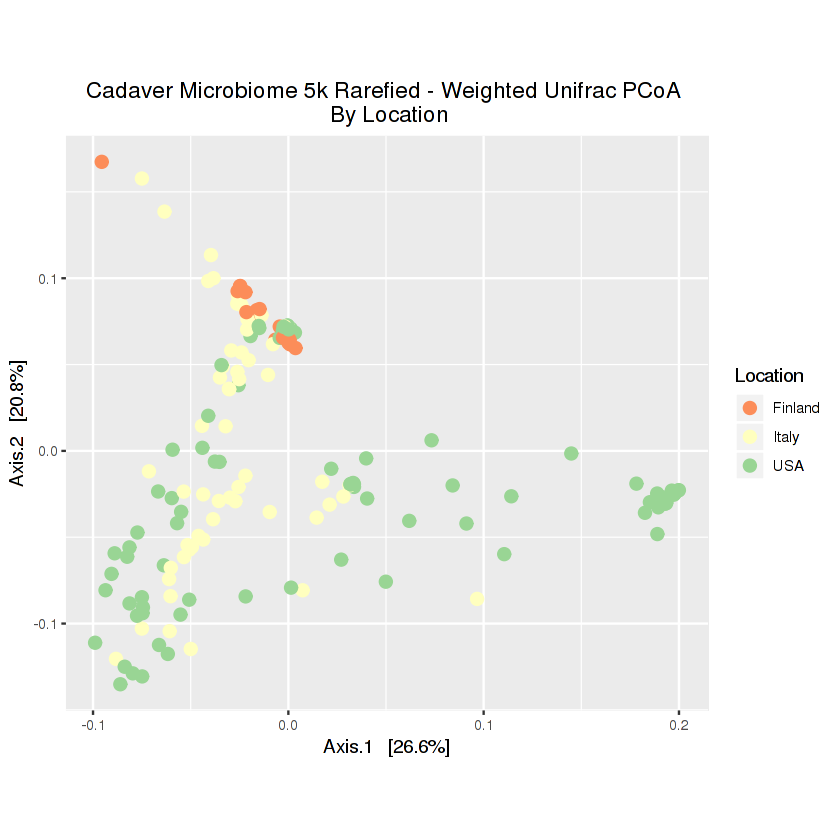

In [42]:
p = plot_ordination(cadaver_5k, cadaver.wunif.log, color = "Location") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Weighted Unifrac PCoA \n By Location") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p                            

In [38]:
cadaver.unif.log = ordinate(cadaver_5k, method = "PCoA", distance = "unifrac")
cadaver.unif.evals = cadaver.unif.log$values$Eigenvalues

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAGCAGCAAGTCTGATGTGAAAGGCGGGGGCTCAACCCCCGGACTGCATTGGAAACTGTTGGTCTTGAGTACCGGAGAGGTAAGCGGAATTCCTAG -- in the phylogenetic tree in the data you provided.”

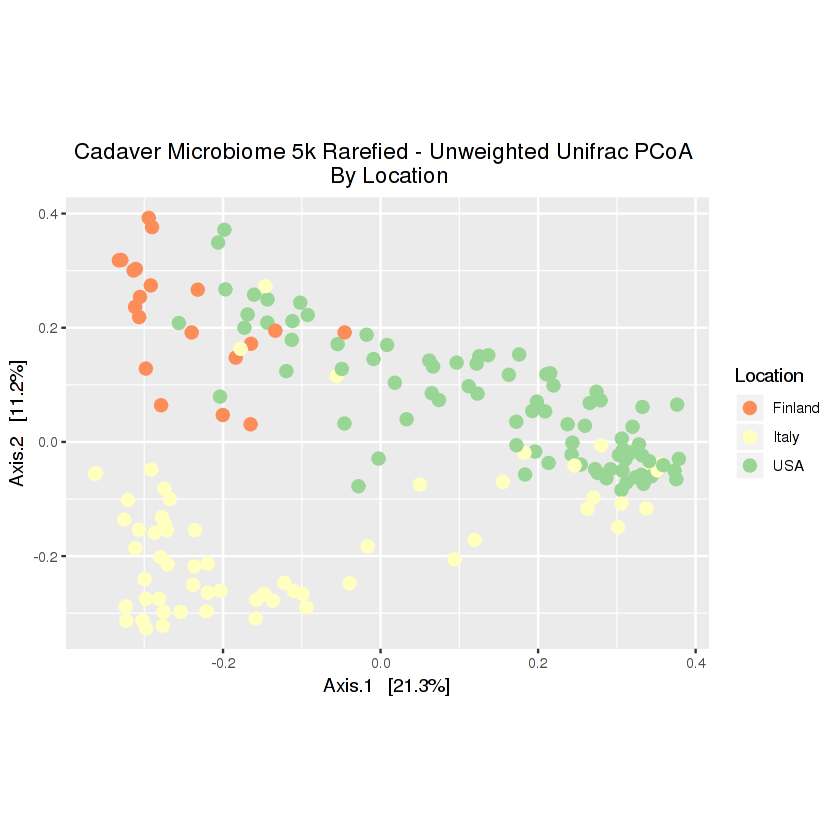

In [43]:
p = plot_ordination(cadaver_5k, cadaver.unif.log, color = "Location") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Unweighted Unifrac PCoA \n By Location") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.unif.evals[2] / cadaver.unif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p    

In [40]:
cadaver.bc.log = ordinate(cadaver_5k, method = "PCoA", distance = "bray")
cadaver.bc.evals = cadaver.bc.log$values$Eigenvalues

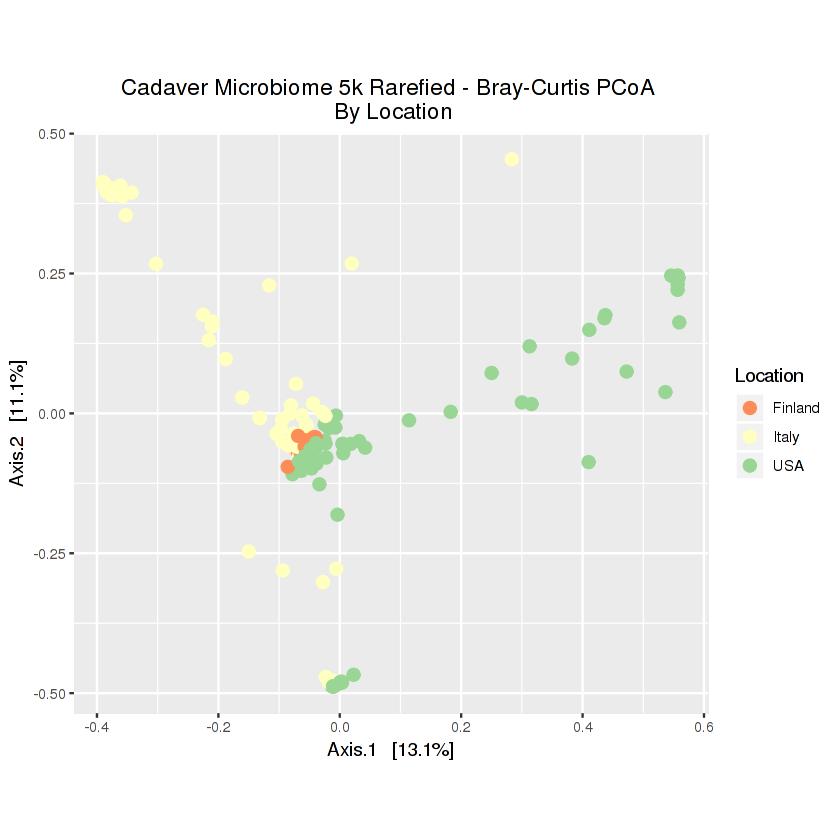

In [44]:
p = plot_ordination(cadaver_5k, cadaver.bc.log, color = "Location") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Bray-Curtis PCoA \n By Location") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.bc.evals[2] / cadaver.bc.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p    

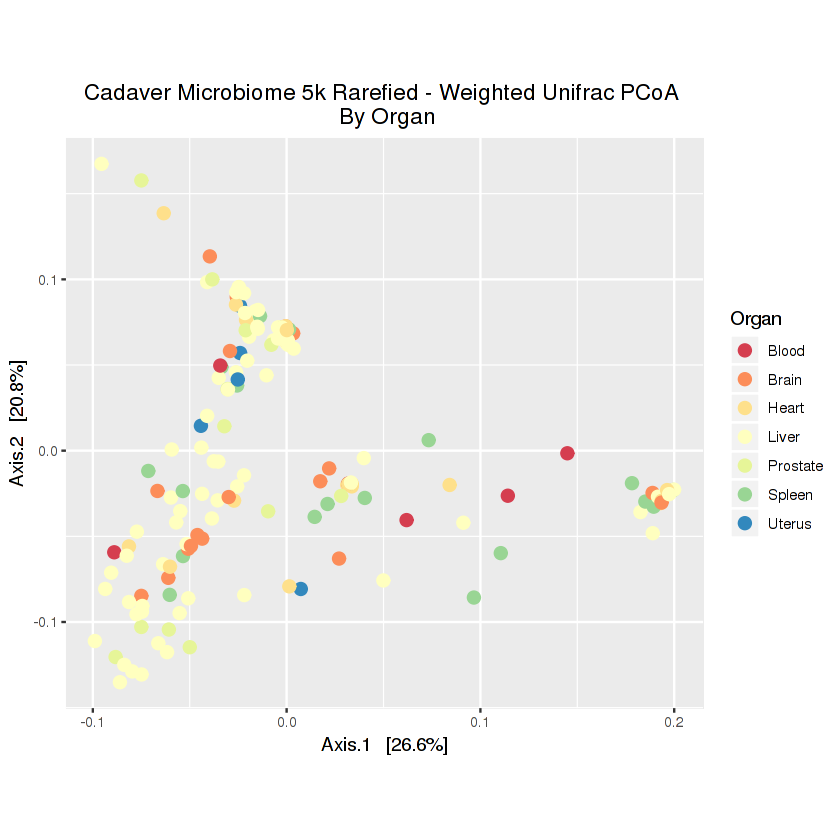

In [45]:
p = plot_ordination(cadaver_5k, cadaver.wunif.log, color = "Organ") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Weighted Unifrac PCoA \n By Organ") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p                            

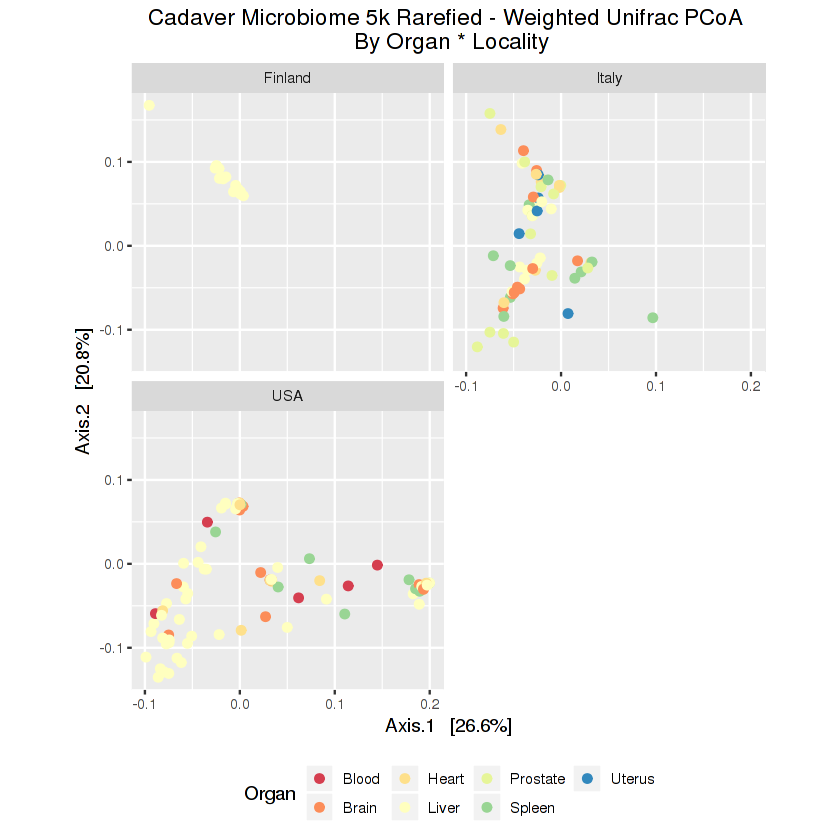

In [86]:
p = plot_ordination(cadaver_5k, cadaver.wunif.log, color = "Organ") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Weighted Unifrac PCoA \n By Organ * Locality") + 
    geom_point(size=2) + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p = p + facet_wrap(~Location, ncol=2)
p = p + theme(legend.position="bottom")
p                            

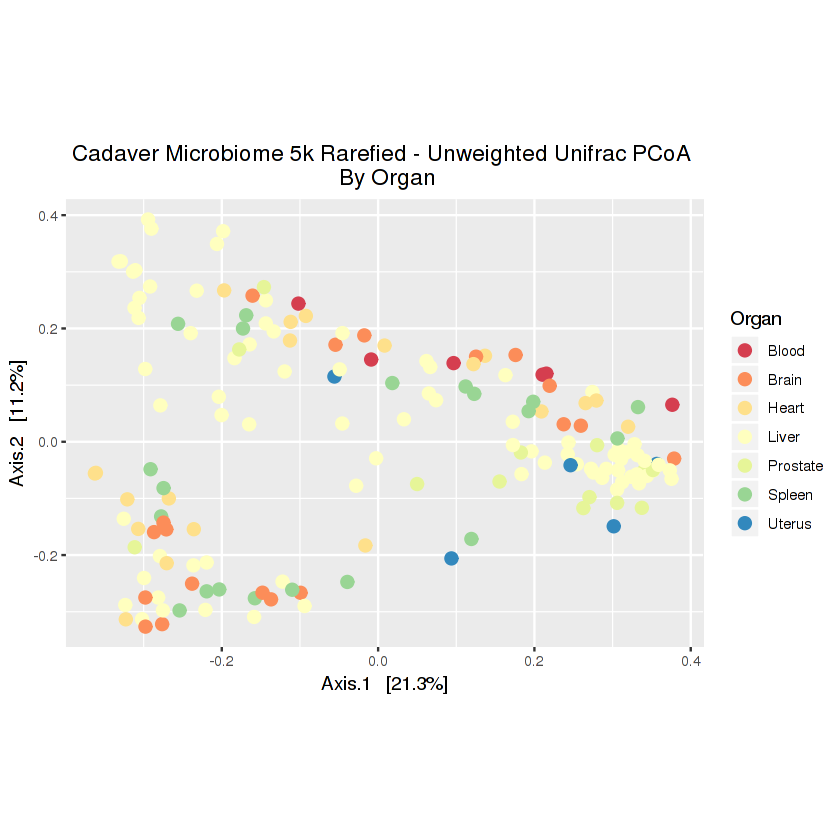

In [46]:
p = plot_ordination(cadaver_5k, cadaver.unif.log, color = "Organ") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Unweighted Unifrac PCoA \n By Organ") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.unif.evals[2] / cadaver.unif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p    

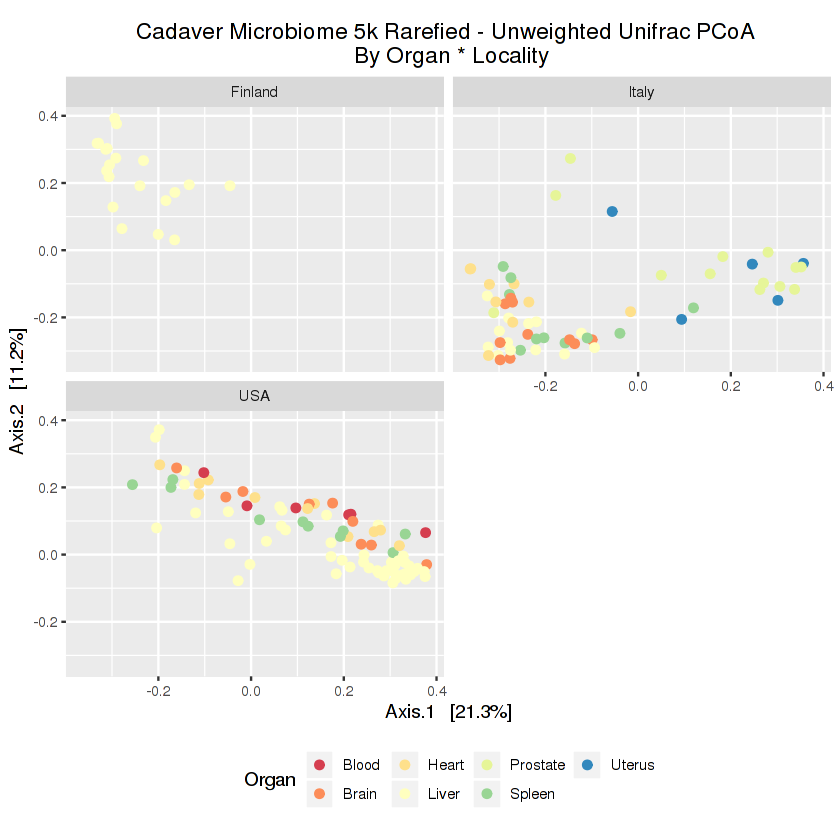

In [87]:
p = plot_ordination(cadaver_5k, cadaver.unif.log, color = "Organ") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Unweighted Unifrac PCoA \n By Organ * Locality") + 
    geom_point(size=2) + 
    coord_fixed(sqrt(cadaver.unif.evals[2] / cadaver.unif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p = p + facet_wrap(~Location, ncol=2)
p = p + theme(legend.position="bottom")
p 

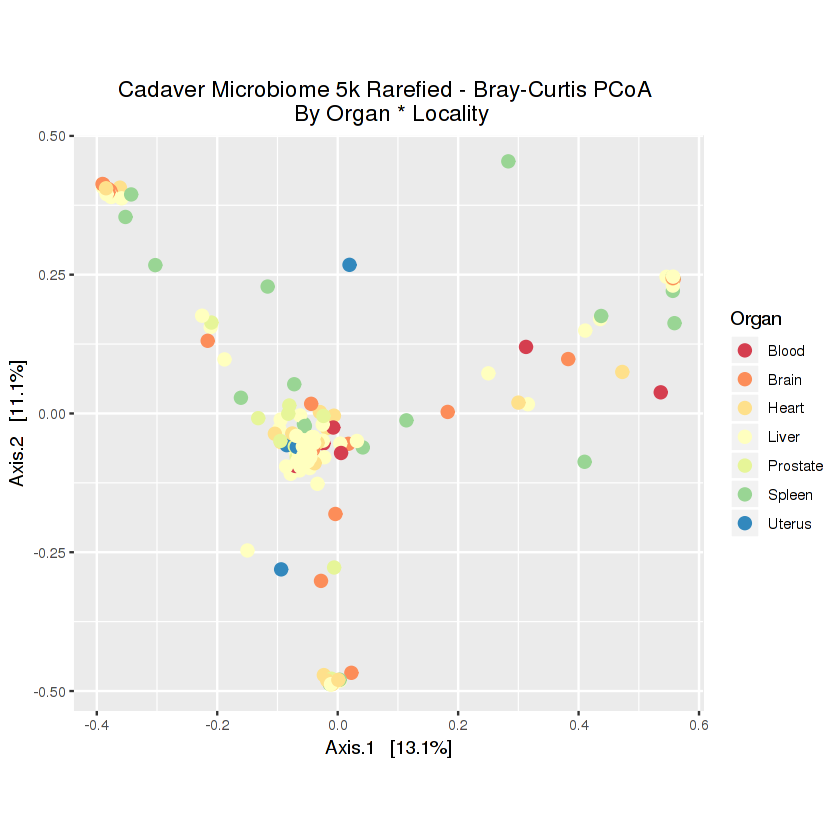

In [88]:
p = plot_ordination(cadaver_5k, cadaver.bc.log, color = "Organ") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Bray-Curtis PCoA \n By Organ * Locality") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.bc.evals[2] / cadaver.bc.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p  

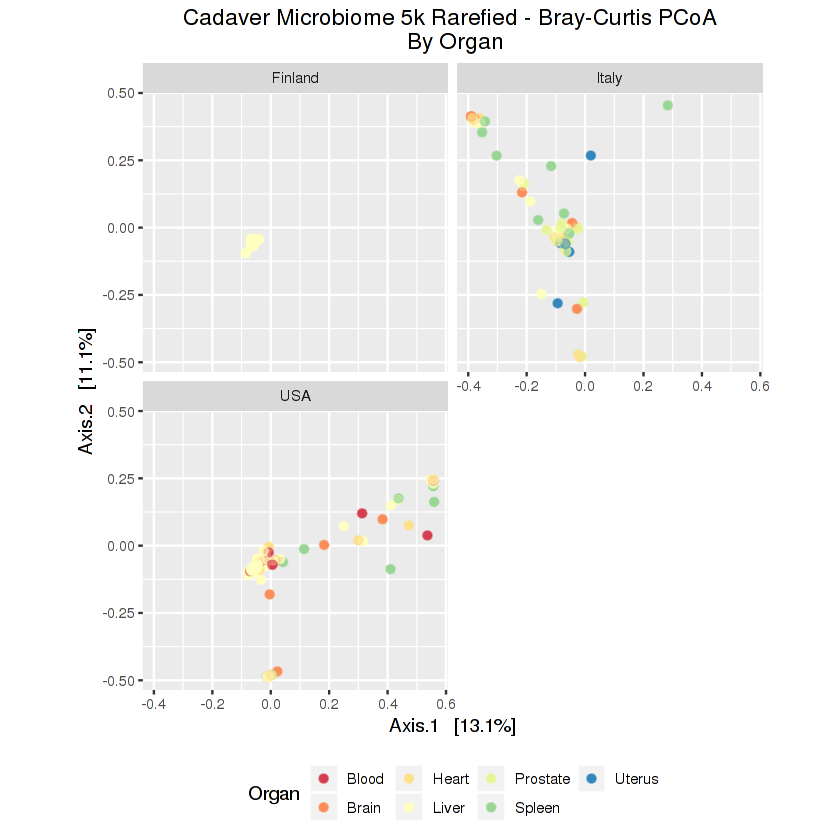

In [84]:
p = plot_ordination(cadaver_5k, cadaver.bc.log, color = "Organ") + 
    ggtitle("Cadaver Microbiome 5k Rarefied - Bray-Curtis PCoA \n By Organ") + 
    geom_point(size=2, alpha=0.5) + 
    coord_fixed(sqrt(cadaver.bc.evals[2] / cadaver.bc.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
#p = p + scale_colour_manual(values = c("Black", "Gray"))
p = p + scale_colour_brewer(palette="Spectral")
p = p + facet_wrap(~Location, ncol=2)
p = p + theme(legend.position="bottom")
p  

#### Betadispersion

In [50]:
sample_tab = data.frame(sample_data(cadaver_nt_5k))

In [54]:
names(sample_tab)[1]<-"SampleID"

In [165]:
#Weighted Unifrac

beta.disp.cadaver.wuf = betadisper(cadaver.dist.wunif,group = sample_data(cadaver_5k)$Location)
beta.disp.cadaver.wuf = beta.disp.cadaver.wuf$distances
beta.disp.cadaver.wuf = data.frame(d = beta.disp.cadaver.wuf, SampleID = names(beta.disp.cadaver.wuf))
beta.disp.cadaver.wuf2 = left_join(beta.disp.cadaver.wuf, sample_tab, by="SampleID")

In [166]:
cadaver.wunif_summary = summary(beta.disp.cadaver.wuf2$d)
cadaver.wunif_summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08321 0.24413 0.28573 0.27934 0.31975 0.53459 

In [170]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ Location, data = beta.disp.cadaver.wuf2, mean)
beta.disp.cadaver.wuf2$Location <-factor(beta.disp.cadaver.wuf2$Location, levels=avg_obs[order(avg_obs$d), "Location"])

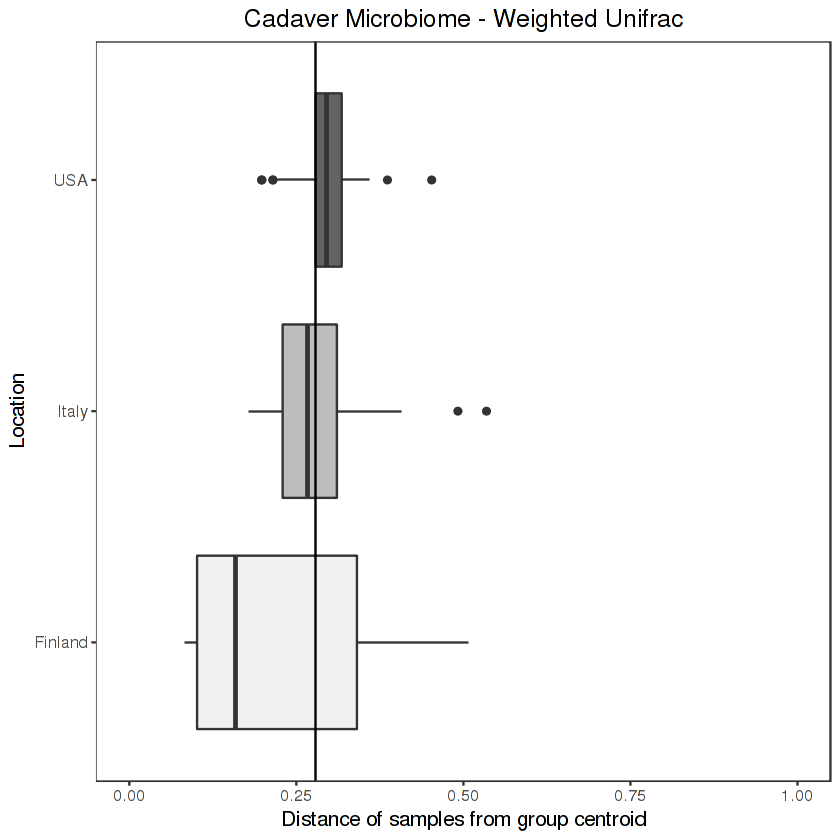

In [171]:
p = ggplot(beta.disp.cadaver.wuf2, aes(x = as.factor(Location), y = d, fill = as.factor(Location))) + ggtitle("Cadaver Microbiome - Weighted Unifrac")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Location") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.wunif_summary"
p = p + geom_hline(yintercept = 0.27934)

p

In [172]:
#Unweighted Unifrac

beta.disp.cadaver.uf = betadisper(cadaver.dist.unif,group = sample_data(cadaver_5k)$Location)
beta.disp.cadaver.uf = beta.disp.cadaver.uf$distances
beta.disp.cadaver.uf = data.frame(d = beta.disp.cadaver.uf, SampleID = names(beta.disp.cadaver.uf))
beta.disp.cadaver.uf2 = left_join(beta.disp.cadaver.uf, sample_tab, by="SampleID")

cadaver.unif_summary = summary(beta.disp.cadaver.uf2$d)
cadaver.unif_summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2754  0.3998  0.4805  0.4795  0.5365  0.7501 

In [173]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ Location, data = beta.disp.cadaver.uf2, mean)
beta.disp.cadaver.uf2$Location <-factor(beta.disp.cadaver.uf2$Location, levels=avg_obs[order(avg_obs$d), "Location"])

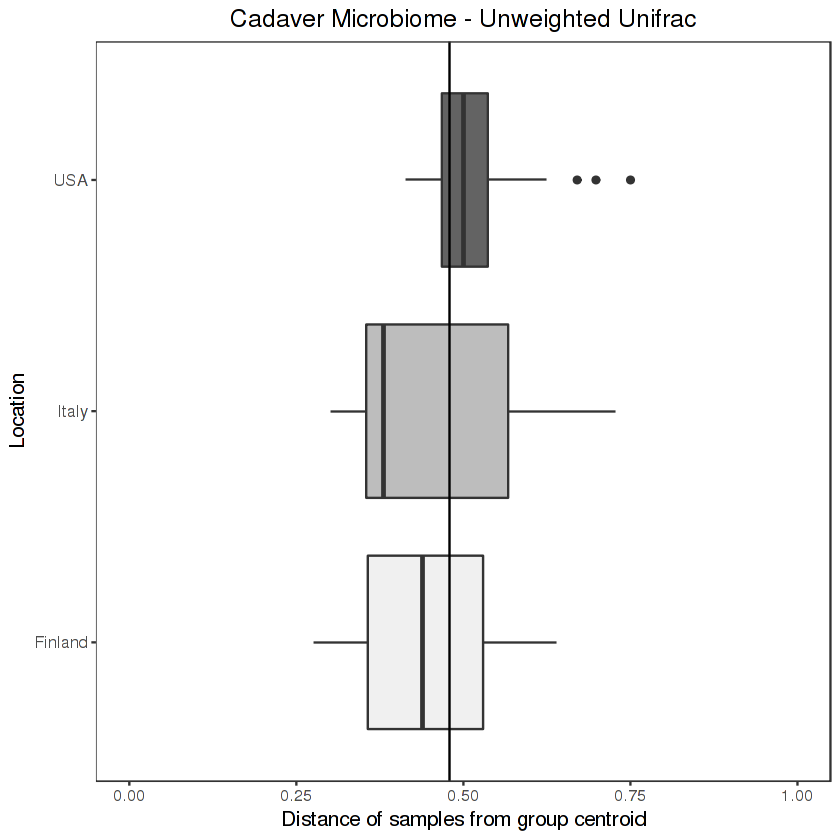

In [175]:
p = ggplot(beta.disp.cadaver.uf2, aes(x = as.factor(Location), y = d, fill = as.factor(Location))) + ggtitle("Cadaver Microbiome - Unweighted Unifrac")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Location") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.unif_summary"
p = p + geom_hline(yintercept = 0.4795)

p

In [176]:
#Bray-Curtis

beta.disp.cadaver.bc = betadisper(cadaver.dist.bc,group = sample_data(cadaver_5k)$Location)
beta.disp.cadaver.bc = beta.disp.cadaver.bc$distances
beta.disp.cadaver.bc = data.frame(d = beta.disp.cadaver.bc, SampleID = names(beta.disp.cadaver.bc))
beta.disp.cadaver.bc2 = left_join(beta.disp.cadaver.bc, sample_tab, by="SampleID")

cadaver.bc_summary = summary(beta.disp.cadaver.bc2$d)
cadaver.bc_summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4042  0.5282  0.6676  0.6304  0.7150  0.7732 

In [177]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ Location, data = beta.disp.cadaver.bc2, mean)
beta.disp.cadaver.bc2$The_manner_of_death <-factor(beta.disp.cadaver.bc2$Location, levels=avg_obs[order(avg_obs$d), "Location"])

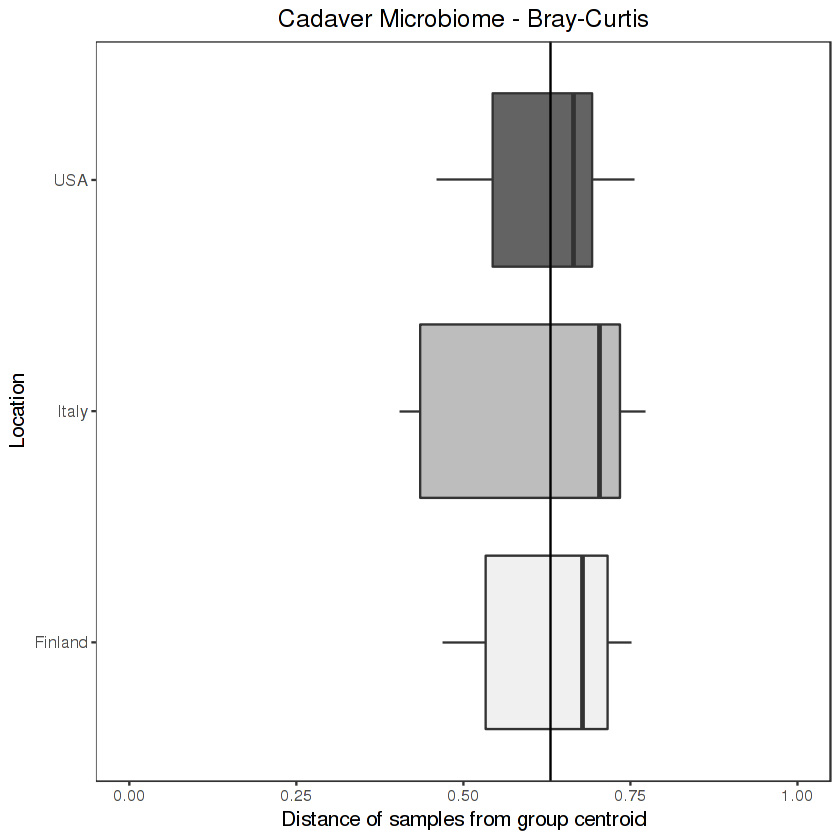

In [179]:
p = ggplot(beta.disp.cadaver.bc2, aes(x = as.factor(Location), y = d, fill = as.factor(Location))) + ggtitle("Cadaver Microbiome - Bray-Curtis")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Location") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.unif_summary"
p = p + geom_hline(yintercept = 0.6304)

p

### Rank Abundance

In [69]:
cadaver5k.mdf = psmelt(cadaver_5k)
#export and add TaxID column (concatenated ranks for specific ID)

In [154]:
cadaver5k.mdf = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/cadaver5k.mdf.csv")

#### Plot top taxa

In [148]:
N = 11

topN = cadaver5k.mdf %>%
    group_by(Rank3) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank3) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank3")

mdf.other = cadaver5k.mdf %>%
    mutate(Rank3.other = ifelse(Rank3 %in% topN, as.character(Rank3), "Other")) %>%
    group_by(Sample, Rank3.other, Organ, Nation) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank3.other, Organ) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank3.other))

Selecting by m


Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”

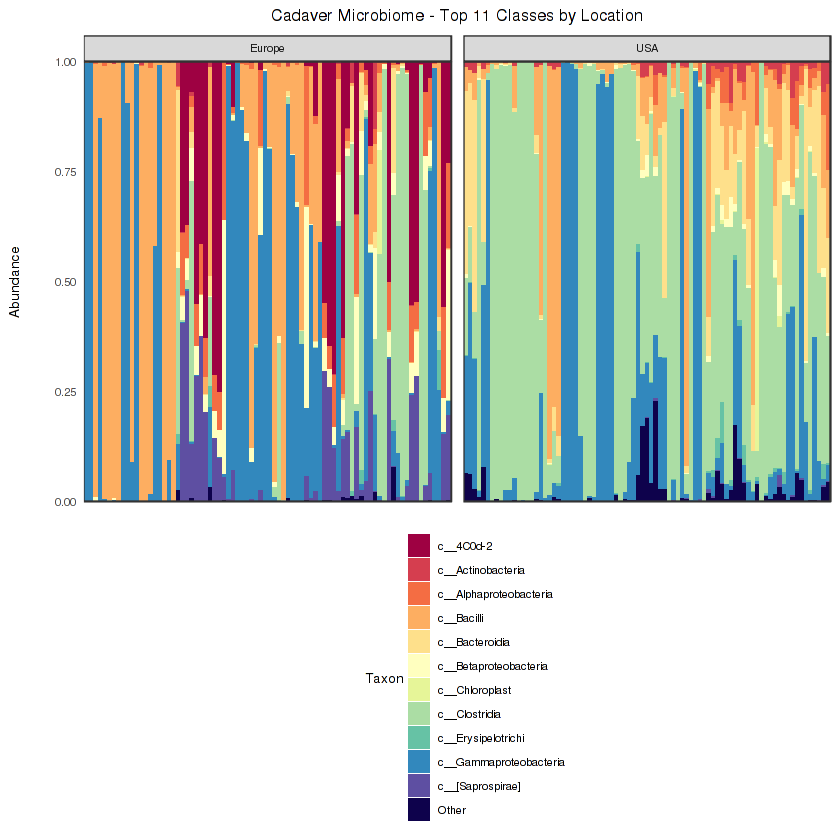

In [150]:
#mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank3.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C") 

p = p + guides(fill = guide_legend(title = "Taxon", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=8, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              #legend.key.size = unit(1, "mm"),
              #legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              legend.key.width = unit(0.5, "mm"),
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))
               
p = p + ggtitle("Cadaver Microbiome - Top 11 Classes by Location")

p = p + facet_wrap(~Nation, scales = "free_x", ncol = 2)

#p = p + facet_grid(Organ ~ Nation, scales = "free_x")

p

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”

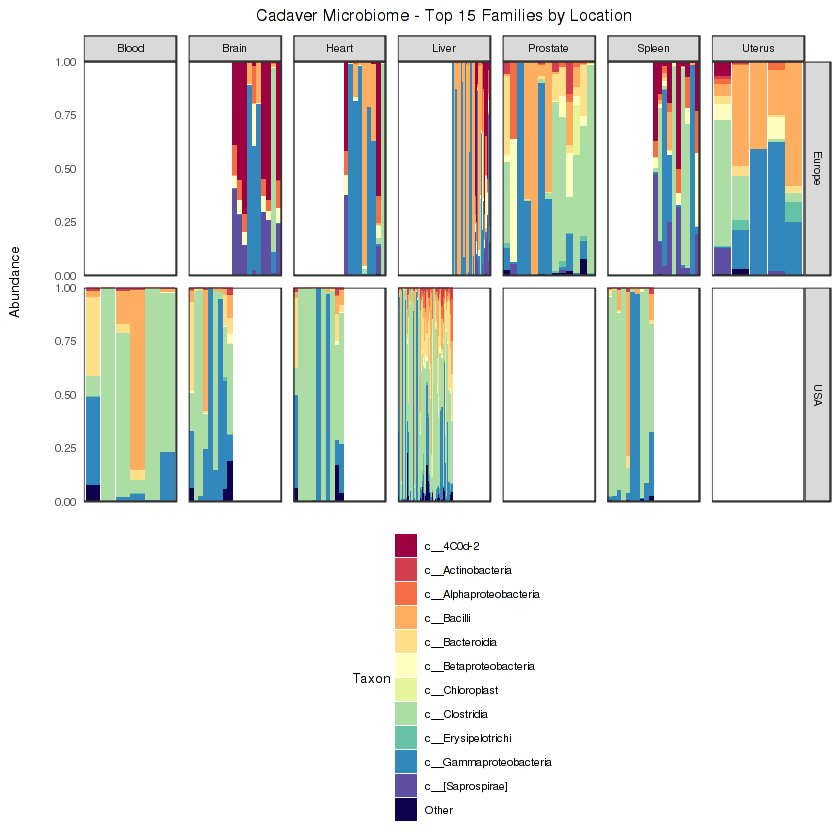

In [138]:
#mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank3.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C") 

p = p + guides(fill = guide_legend(title = "Taxon", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=8, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              #legend.key.size = unit(1, "mm"),
              #legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              legend.key.width = unit(0.5, "mm"),
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))
               
p = p + ggtitle("Cadaver Microbiome - Top 15 Families by Location")

#p = p + facet_wrap(~Location, scales = "free_x", ncol = 4)

p = p + facet_grid(Nation ~ Organ, scales = "free_x")

p

#### Plot top 10 most abundant families

In [161]:
N = 11

topN = cadaver5k.mdf %>%
    group_by(Rank6) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank6) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank6")

mdf.other = cadaver5k.mdf %>%
    mutate(Rank6.other = ifelse(Rank6 %in% topN, as.character(Rank6), "Other")) %>%
    group_by(Sample, Rank6.other, Sex, bmi_category) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank6.other, Sex, bmi_category) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank6.other))

Selecting by m


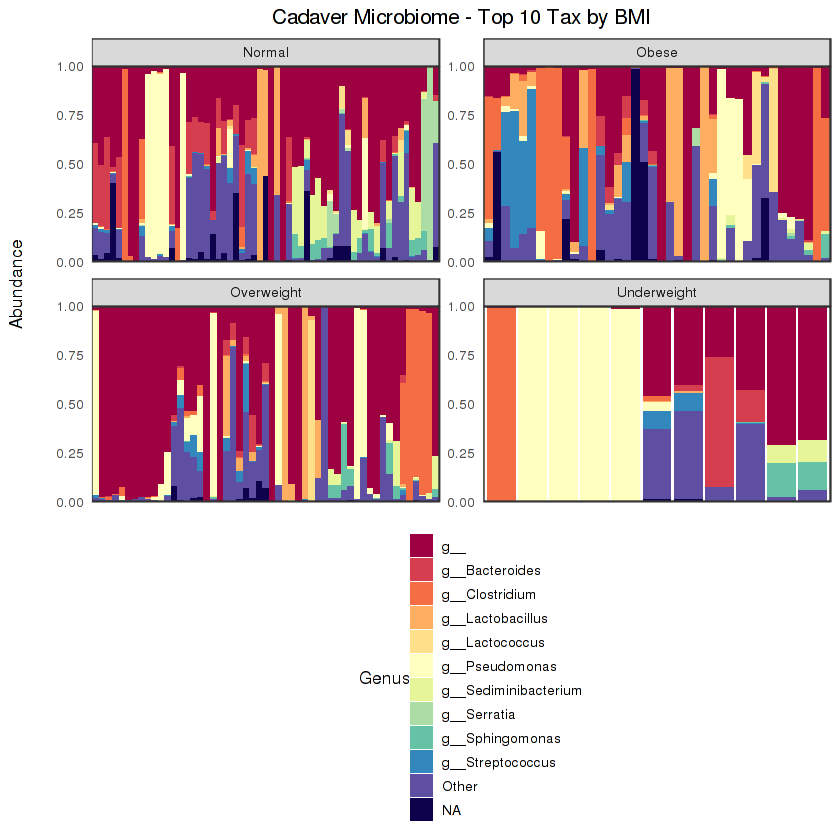

In [164]:
p = ggplot(mdf.other, aes(x=factor(Sample), y = Abundance, fill = Rank6.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Genus", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=10, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              #legend.key.size = unit(1, "mm"),
              #legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Tax by BMI")

p = p + facet_wrap(~bmi_category, shrink = TRUE, scales = "free", ncol=2)

p

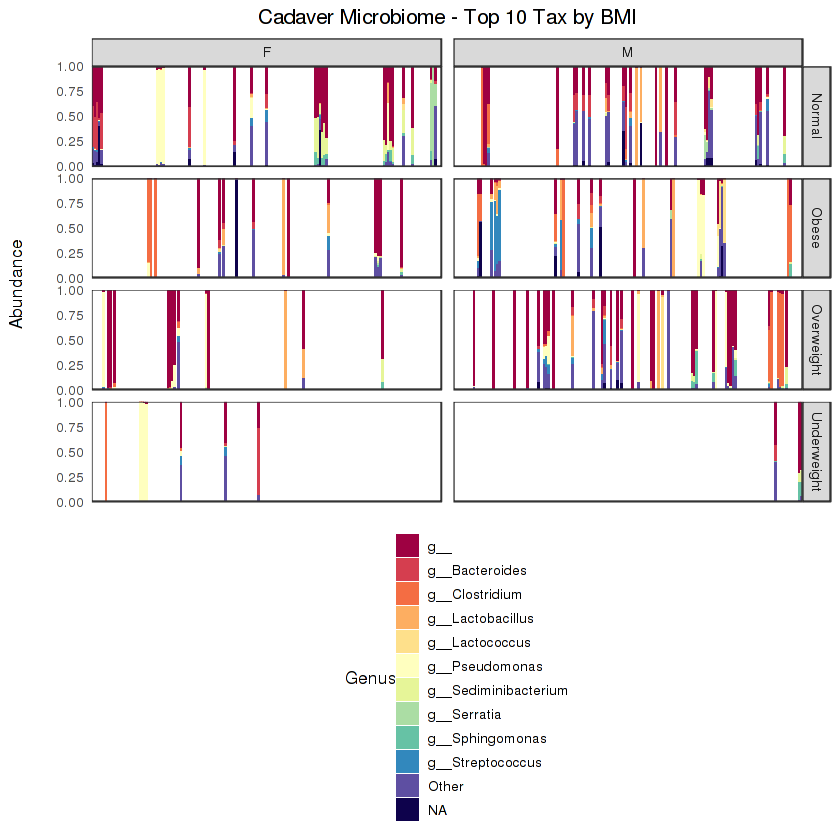

In [163]:
p = ggplot(mdf.other, aes(x=factor(Sample), y = Abundance, fill = Rank6.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Genus", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=10, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              #legend.key.size = unit(1, "mm"),
              #legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Tax by BMI")

p = p + facet_grid(bmi_category~Sex)

p

#### Top 10 Orders by Location

In [186]:
N = 11

topN = cadaver5k.mdf %>%
    group_by(Rank4) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank4) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank4")

mdf.other = cadaver5k.mdf %>%
    mutate(Rank4.other = ifelse(Rank4 %in% topN, as.character(Rank4), "Other")) %>%
    group_by(Sample, Rank4.other, Location) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank4.other, Location) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank4.other))

Selecting by m


Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”

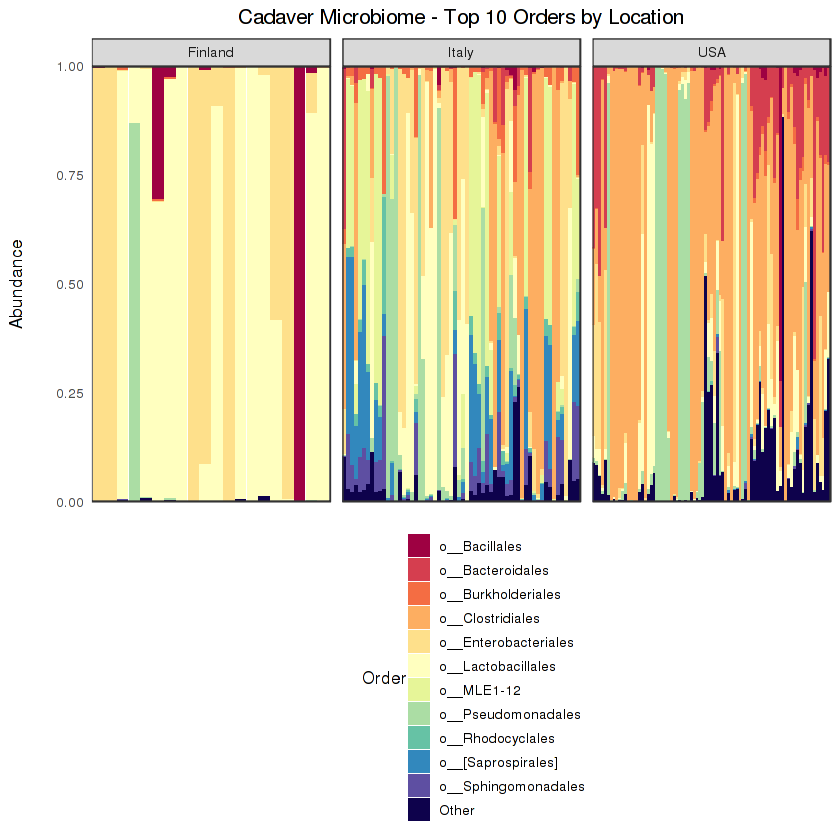

In [187]:
mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank4.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Order", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=10, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              #legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Orders by Location")

p = p + facet_wrap(~Location, shrink = TRUE, scales = "free_x", ncol=4)

p

#### Top 10 Orders by Manner of Death

In [189]:
N = 11

topN = cadaver5k.mdf %>%
    group_by(Rank4) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank4) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank4")

mdf.other = cadaver5k.mdf %>%
    mutate(Rank4.other = ifelse(Rank4 %in% topN, as.character(Rank4), "Other")) %>%
    group_by(Sample, Rank4.other, The_manner_of_death) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank4.other, The_manner_of_death) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank4.other))

Selecting by m


Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Spectral is 11
Returning the palette you asked for with that many colors
”

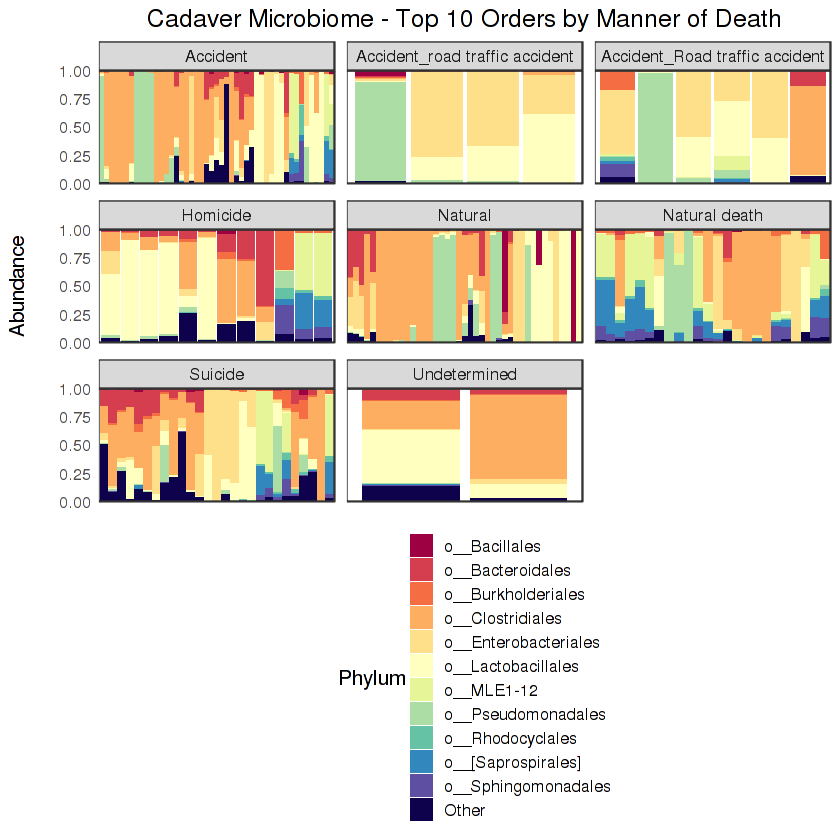

In [191]:
mdf.other$The_manner_of_death <- factor(mdf.other$The_manner_of_death)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank4.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Phylum", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=12, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              #legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Orders by Manner of Death")

p = p + facet_wrap(~The_manner_of_death, shrink = TRUE, scales = "free_x")

p

### Prep data for Piphillin analyses

In [212]:
Finland = subset_samples(cadaver_nt_5k, Location=="Finland")
Italy = subset_samples(cadaver_nt_5k, Location=="Italy")
Europe = merge_phyloseq(Finland,Italy)
Europe = prune_taxa(taxa_sums(Europe)>0, Europe)
Europe.df = data.frame(otu_table(Europe))
write.table(Europe.df, "Europe_otu.txt", sep = "\t", row.names = TRUE, col.names = TRUE)


In [222]:
head(Europe_metadata)

,X.SampleID,BarcodeSequence,LinkerPrimerSequence,RTL_run,Case_no,Sex,Age,Ethnicity,Order,Location,...,Organ,RTLID,Samplename,Cause_of_death,The_manner_of_death,Height_cm,Weight_kg,bmi,bmi_category,Description
4885.48Liver,4885.48Liver,AAAACAGT,GTGCCAGCMGCCGCGGTAA,4885,L638,M,65,C,4885,Finland,...,Liver,48,48-MS515F,Acute tubulo-interstitial nephritis,Natural,171,73,24.96,normal,4885.48_Liver
4885.9Liver,4885.9Liver,AAAACCCA,GTGCCAGCMGCCGCGGTAA,4885,L537,M,64,C,4885,Finland,...,Liver,9,9-MS515F,Alcoholic cardiomyopathy,Natural,178,146,46.08,obese,4885.9_Liver
4885.19Liver,4885.19Liver,AAAACAAT,GTGCCAGCMGCCGCGGTAA,4885,L572,M,75,C,4885,Finland,...,Liver,19,19-MS515F,Atherosclerotic heart disease,Natural,176,78,25.18,overweight,4885.19_Liver
4885.47Liver,4885.47Liver,AAAACAGG,GTGCCAGCMGCCGCGGTAA,4885,L637,M,75,C,4885,Finland,...,Liver,47,47-MS515F,Ischaemic cardiomyopathy,Natural,182,94,28.38,overweight,4885.47_Liver
4885.26Liver,4885.26Liver,AAAACACA,GTGCCAGCMGCCGCGGTAA,4885,L584,M,68,C,4885,Finland,...,Liver,26,26-MS515F,Duodenal ulcer,Natural,172,61,20.62,normal,4885.26_Liver
4885.8Liver,4885.8Liver,AAAACCAT,GTGCCAGCMGCCGCGGTAA,4885,L534,M,72,C,4885,Finland,...,Liver,8,8-MS515F,Drowning,Accident,170,100,34.60,obese,4885.8_Liver


In [214]:
setwd("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/")

Europe_metadata = data.frame(sample_data(Europe))
write.table(Europe_metadata, "Europe_metadata.txt", sep = "\t", row.names = TRUE, col.names = TRUE)

Italy_metadata = data.frame(sample_data(Italy))
write.table(Italy_metadata, "Italy_metadata.txt", sep = "\t", row.names = TRUE, col.names = TRUE)

Finland_metadata = data.frame(sample_data(Finland))
write.table(Finland_metadata, "Finland_metadata.txt", sep = "\t", row.names = TRUE, col.names = TRUE)

USA_metadata = data.frame(sample_data(USA))
write.table(USA_metadata, "USA_metadata.txt", sep = "\t", row.names = TRUE, col.names = TRUE)


In [227]:
Finland = subset_samples(cadaver_nt_5k, Location=="Finland")
Italy = subset_samples(cadaver_nt_5k, Location=="Italy")
USA = subset_samples(cadaver_nt_5k, Location=="USA")

Finland = prune_taxa(taxa_sums(Finland)>0, Finland)
Italy = prune_taxa(taxa_sums(Italy)>0, Italy)
USA = prune_taxa(taxa_sums(USA)>0, USA)

Finland.df = data.frame(otu_table(Finland))
Italy.df = data.frame(otu_table(Italy))
USA.df = data.frame(otu_table(USA))
                      
Finland.taxa = data.frame(tax_table(Finland))
Italy.taxa = data.frame(tax_table(Italy))
USA.taxa = data.frame(tax_table(USA))
                 
setwd("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/")

#write.table(Finland.df, "Finland_otu.txt", sep = "\t", row.names = TRUE, col.names = TRUE)
#write.table(Italy.df, "Italy_otu.txt", sep = "\t", row.names = TRUE, col.names = TRUE)
#write.table(USA.df, "USA_otu.txt", sep = "\t", row.names = TRUE, col.names = TRUE)



In [196]:
liver = subset_samples(cadaver_nt_5k, Organ=="Liver")
heart = subset_samples(cadaver_nt_5k, Organ=="Heart")
spleen = subset_samples(cadaver_nt_5k, Organ=="Spleen")
uterus = subset_samples(cadaver_nt_5k, Organ=="Uterus")
brain = subset_samples(cadaver_nt_5k, Organ=="Brain")
blood = subset_samples(cadaver_nt_5k, Organ=="Blood")
prostate = subset_samples(cadaver_nt_5k, Organ=="Prostate")

liver = prune_taxa(taxa_sums(liver)>0, liver)
heart = prune_taxa(taxa_sums(heart)>0, heart)
spleen = prune_taxa(taxa_sums(spleen)>0, spleen)
uterus = prune_taxa(taxa_sums(uterus)>0, uterus)
brain = prune_taxa(taxa_sums(brain)>0, brain)
blood = prune_taxa(taxa_sums(blood)>0, blood)
prostate = prune_taxa(taxa_sums(prostate)>0, prostate)

cadaver_nt_5k = prune_taxa(taxa_sums(cadaver_nt_5k)>0, cadaver_nt_5k)


In [200]:
liver.df = data.frame(otu_table(liver))
heart.df = data.frame(otu_table(heart))
spleen.df = data.frame(otu_table(spleen))
uterus.df = data.frame(otu_table(uterus))
brain.df = data.frame(otu_table(brain))
blood.df = data.frame(otu_table(blood))
prostate.df = data.frame(otu_table(prostate))
cadaver_nt_5k.df = data.frame(otu_table(cadaver_nt_5k))

setwd("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/")

write.csv(liver.df, "liver_otu.csv")
write.csv(heart.df, "heart_otu.csv")
write.csv(spleen.df, "spleen_otu.csv")
write.csv(uterus.df, "uterus_otu.csv")
write.csv(brain.df, "brain_otu.csv")
write.csv(blood.df, "blood_otu.csv")
write.csv(prostate.df, "prostate_otu.csv")
write.csv(cadaver_nt_5k.df, "cadaver_5k_otu_table.csv")

In [202]:
cadaver_nt_5k

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1858 taxa and 163 samples ]
sample_data() Sample Data:       [ 163 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 1858 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1858 tips and 1856 internal nodes ]

In [307]:
Italy_liver = subset_samples(liver, Location=="Italy")
Finland_liver = subset_samples(liver, Location=="Finland")
USA_liver = subset_samples(liver, Location=="USA")
Europe_liver = merge_phyloseq(Italy_liver, Finland_liver)

Euro_spleen = subset_samples(spleen, Location=="Italy")
#Finland_spleen = subset_samples(spleen, Location=="Finland") NONE
USA_spleen = subset_samples(spleen, Location=="USA")

Euro_liver = prune_taxa(taxa_sums(Europe_liver)>0, Europe_liver)
USA_liver = prune_taxa(taxa_sums(USA_liver)>0, USA_liver)
Euro_spleen = prune_taxa(taxa_sums(Euro_spleen)>0, Euro_spleen)
USA_spleen = prune_taxa(taxa_sums(USA_spleen)>0, USA_spleen)

Euro_liver.df = data.frame(otu_table(Euro_liver))
USA_liver.df = data.frame(otu_table(USA_liver))
Euro_spleen.df = data.frame(otu_table(Euro_spleen))
USA_spleen.df = data.frame(otu_table(USA_spleen))

write.csv(Euro_liver.df, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/Euro_liver_otu.csv")
write.csv(USA_liver.df, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/USA_liver_otu.csv")
write.csv(Euro_spleen.df, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/Euro_spleen_otu.csv")
write.csv(USA_spleen.df, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/OTU_files/USA_spleen_otu.csv")

In [ ]:
Euro_liver_md = data.frame(sample_data(Euro_liver))
Euro_spleen_md = data.frame(sample_data(Euro_spleen))
USA_liver_md = data.frame(sample_data(USA_liver))
USA_spleen_md = data.frame(sample_data(USA_spleen))

write.csv(Euro_liver_md, "Euro_liver_md.csv")
write.csv(Euro_spleen_md, "Euro_spleen_md.csv")
write.csv(USA_liver_md, "USA_liver_md.csv")
write.csv(USA_spleen_md, "USA_spleen_md.csv")

### ANCOM with Covariates

In [53]:
library(exactRankTests)
library(nlme)
library(ggplot2)

ancom.W = function(otu_data,var_data,
                   adjusted,repeated,
                   main.var,adj.formula,
                   repeat.var,long,rand.formula,
                   multcorr,sig){
  
  n_otu=dim(otu_data)[2]-1
  
  otu_ids=colnames(otu_data)[-1]
  
  if(repeated==F){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID",all.y=T),row.names=NULL)
    #data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var)],by="Sample.ID",all.y=T),row.names=NULL)
  }else if(repeated==T){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID"),row.names=NULL)
   # data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var,repeat.var)],by="Sample.ID"),row.names=NULL)
  }
  
  base.formula = paste0("lr ~ ",main.var)
  if(repeated==T){
    repeat.formula = paste0(base.formula," | ", repeat.var)
  }
  if(adjusted==T){
    adjusted.formula = paste0(base.formula," + ", adj.formula)
  }
  
  if( adjusted == F & repeated == F ){
    fformula  <- formula(base.formula)
  } else if( adjusted == F & repeated == T & long == T ){
    fformula  <- formula(base.formula)   
  }else if( adjusted == F & repeated == T & long == F ){
    fformula  <- formula(repeat.formula)   
  }else if( adjusted == T & repeated == F  ){
    fformula  <- formula(adjusted.formula)   
  }else if( adjusted == T & repeated == T  ){
    fformula  <- formula(adjusted.formula)   
  }else{
    stop("Problem with data. Dataset should contain OTU abundances, groups, 
         and optionally an ID for repeated measures.")
  }
  
  
  
    if( repeated==FALSE & adjusted == FALSE){
       if( length(unique(data_comp[,which(colnames(data_comp)==main.var)]))==2 ){
          tfun <- exactRankTests::wilcox.exact
       } else{
          tfun <- stats::kruskal.test
    }
    }else if( repeated==FALSE & adjusted == TRUE){
      tfun <- stats::aov
    }else if( repeated== TRUE & adjusted == FALSE & long == FALSE){
      tfun <- stats::friedman.test
    }else if( repeated== TRUE & adjusted == FALSE & long == TRUE){
      tfun <- nlme::lme
    }else if( repeated== TRUE & adjusted == TRUE){
      tfun <- nlme::lme
    }
  
  logratio.mat <- matrix(NA, nrow=n_otu, ncol=n_otu)
  for(ii in 1:(n_otu-1)){
    for(jj in (ii+1):n_otu){
      data.pair <- data_comp[,which(colnames(data_comp)%in%otu_ids[c(ii,jj)])]
      lr <- log((1+as.numeric(data.pair[,1]))/(1+as.numeric(data.pair[,2])))
      
      lr_dat <- data.frame( lr=lr, data_comp,row.names=NULL )
      
      if(adjusted==FALSE&repeated==FALSE){  ## Wilcox, Kruskal Wallis
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==FALSE&repeated==TRUE&long==FALSE){ ## Friedman's 
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==TRUE&repeated==FALSE){ ## ANOVA
        model=tfun(formula=fformula, data = lr_dat,na.action=na.omit)   
        picker=which(gsub(" ","",row.names(summary(model)[[1]]))==main.var)  
        logratio.mat[ii,jj] <- summary(model)[[1]][["Pr(>F)"]][picker]
      }else if(repeated==TRUE&long==TRUE){ ## GEE
        model=tfun(fixed=fformula,data = lr_dat,
                   random = formula(rand.formula),
                   correlation=corAR1(),
                   na.action=na.omit)   
        picker=which(gsub(" ","",row.names(anova(model)))==main.var)
        logratio.mat[ii,jj] <- anova(model)[["p-value"]][picker]
      }
      
    }
  } 
  
  ind <- lower.tri(logratio.mat)
  logratio.mat[ind] <- t(logratio.mat)[ind]
  
  
  logratio.mat[which(is.finite(logratio.mat)==FALSE)] <- 1
  
  mc.pval <- t(apply(logratio.mat,1,function(x){
    s <- p.adjust(x, method = "BH")
    return(s)
  }))
  
  a <- logratio.mat[upper.tri(logratio.mat,diag=FALSE)==TRUE]
  
  b <- matrix(0,ncol=n_otu,nrow=n_otu)
  b[upper.tri(b)==T] <- p.adjust(a, method = "BH")
  diag(b)  <- NA
  ind.1    <- lower.tri(b)
  b[ind.1] <- t(b)[ind.1]
  
  #########################################
  ### Code to extract surrogate p-value
  surr.pval <- apply(mc.pval,1,function(x){
    s0=quantile(x[which(as.numeric(as.character(x))<sig)],0.95)
    # s0=max(x[which(as.numeric(as.character(x))<alpha)])
    return(s0)
  })
  #########################################
  ### Conservative
  if(multcorr==1){
    W <- apply(b,1,function(x){
      subp <- length(which(x<sig))
    })
    ### Moderate
  } else if(multcorr==2){
    W <- apply(mc.pval,1,function(x){
      subp <- length(which(x<sig))
    })
    ### No correction
  } else if(multcorr==3){
    W <- apply(logratio.mat,1,function(x){
      subp <- length(which(x<sig))
    })
  }
  
  return(W)
  }



ANCOM.main = function(OTUdat,Vardat,
                      adjusted,repeated,
                      main.var,adj.formula,
                      repeat.var,longitudinal,
                      random.formula,
                      multcorr,sig,
                      prev.cut){
  
  p.zeroes=apply(OTUdat[,-1],2,function(x){
    s=length(which(x==0))/length(x)
  })
  
  zeroes.dist=data.frame(colnames(OTUdat)[-1],p.zeroes,row.names=NULL)
  colnames(zeroes.dist)=c("Taxon","Proportion_zero")
  
  zero.plot = ggplot(zeroes.dist, aes(x=Proportion_zero)) + 
              geom_histogram(binwidth=0.1,colour="black",fill="white") + 
              xlab("Proportion of zeroes") + ylab("Number of taxa") +
              theme_bw()
  
  #print(zero.plot)
  
  OTUdat.thinned=OTUdat
  OTUdat.thinned=OTUdat.thinned[,c(1,1+which(p.zeroes<prev.cut))]
  
  otu.names=colnames(OTUdat.thinned)[-1]
  
  W.detected   <- ancom.W(OTUdat.thinned,Vardat,
                          adjusted,repeated,
                          main.var,adj.formula,
                          repeat.var,longitudinal,random.formula,
                          multcorr,sig)
  
  W_stat       <- W.detected
  
  
  ### Bubble plot
  
  W_frame = data.frame(otu.names,W_stat,row.names=NULL)
  W_frame = W_frame[order(-W_frame$W_stat),]
  
  W_frame$detected_0.9=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.8=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.7=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.6=rep(FALSE,dim(W_frame)[1])
  
  W_frame$detected_0.9[which(W_frame$W_stat>0.9*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.8[which(W_frame$W_stat>0.8*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.7[which(W_frame$W_stat>0.7*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.6[which(W_frame$W_stat>0.6*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  
  final_results=list(W_frame,zero.plot)
  names(final_results)=c("W.taxa","PLot.zeroes")
  return(final_results)
    }

 Package ‘exactRankTests’ is no longer under development.
 Please consider using package ‘coin’ instead.


Attaching package: ‘nlme’

The following object is masked from ‘package:IRanges’:

    collapse

The following object is masked from ‘package:dplyr’:

    collapse



### European Organs - covariates: Sex, Age, Location, PMI

In [47]:
#READ IN DATA

Europe_otu = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/Europe_otu.csv")
Europe_meta = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/Europe_meta.csv")

names(Europe_otu)[1]<-"Sample.ID"
names(Europe_meta)[1]<-"Sample.ID"

In [151]:
#RUN ANCOM

comparison_test=ANCOM.main(OTUdat=Europe_otu,
                           Vardat=Europe_meta,
                           adjusted=TRUE,
                           repeated=F,
                           main.var="Organ",
                           adj.formula="Sex+Location+Age+PMI", #covariates
                           repeat.var=NULL,
                           longitudinal=FALSE,
                           random.formula=NULL,
                           multcorr=2, #2 corresponds to BH FDR correction
                           sig=0.05,
                           prev.cut=0.90)

Europe_Org_by_sex_and_loc.ancom = comparison_test$W.taxa
head(Europe_Org_by_sex_loc_age_pmi.ancom)

In [153]:
write.csv(Europe_Org_by_sex_loc_age_pmi.ancom, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/Europe_Org_by_sexlocPMIloc.ancom.csv")

In [159]:
#tax_table = tax_table(cadaver)
tax_table = read.csv("/group/gilbert-lab/Lutz/Cadaver/tax_table.csv")
head(tax_table)
head(Europe_Org_by_sex_loc_age_pmi.ancom)

otu.names,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCATCACAAGTCAGAAGTGAAAATCCGGGGCTCAACCCCGGAACTGCTTTTGAAACTGTGGAGCTGGAGTGCAGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__,s__
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCTTTGCAAGTCTGACGTGAAAATCCGGGGCTCAACCCCGGAACTGCGTTGGAAACTGTGAGGCTTGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__,s__
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCTTTGCAAGTCTGACGTGAAACTCCGGGGCTCAACTCCGGAACTGCGTTGGAAACTGTAAGGCTTGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAGGCAAGTCTGAAGTGAAAGCCCGGGGCTTAACCGCGGGACTGCTTTGGAAACTGTCTGGCTGGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,NA,NA
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAGGCAAGTCTGAAGTGAAAGCCCGGTGCTTAACGCCGGGACTGCTTTGGAAACTGTTTGGCTGGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAGGCAAGTCTGAAGTGAAAGCCCGGTGCTTAACGTCGGGACTGCTTTGGAAACTGTTTAGCTGGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__


,otu.names,W_stat,detected_0.9,detected_0.8,detected_0.7,detected_0.6
29,GACGTAGGATGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGTTCGTAGGTGGTTTGTTAAGTTTGGTGTTAAAGATTGGGGCTCAACCCTGAAACTGCACTGAATACTGGCAGACTCGAGTGTGGTAGAGGCTAGTGGAATTCCCAG,86,TRUE,TRUE,TRUE,TRUE
80,TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCAGGTAAGTCAGTGGTGAAATCCTGGAGCTTAACTCCAGAACTGCCATTGATACTATCTGTCTTGAATATTGTGGAGGTAAGCGGAATATGTCA,86,TRUE,TRUE,TRUE,TRUE
33,TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGAGACTGCATCGCTTGAATCCAGGAGAGGTCAGTGGAATTCCGAG,85,TRUE,TRUE,TRUE,TRUE
77,TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGTTTGTAAGTCAGTGGTGAAATCCCCGAGCTTAACTTGGGAACTGCCATTGATACTGCAAGTCTTGAATTTTCTGGAGGTAAGCGGAATATGTCA,85,TRUE,TRUE,TRUE,TRUE
13,TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGAGAGTGCAGGCGGTTTTCTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGGAGAAGTGCATCGGAAACTGGATAACTTGAGTGCAGAAGAGGGTAGTGGAACTCCATG,79,TRUE,TRUE,TRUE,TRUE
64,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTCGTAAGACAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTTTGTGACTGCGAGGCTAGAGTACGGCAGAGGGGGGTGGAATTCCACG,79,TRUE,TRUE,TRUE,TRUE


In [161]:
sig_taxa <- left_join(Europe_Org_by_sex_and_loc.ancom, tax_table)
write.csv(sig_taxa, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/Europe_Org_by_sexlocPMIloc.ancom.sigres.taxa.csv")

Joining, by = "otu.names"
Warning message:
“Column `otu.names` joining factors with different levels, coercing to character vector”

In [70]:
### Subset OTUs ID'd by ANCOM


subset <- subset(otu_table(cadaver_nt), 
        rownames(otu_table(cadaver_nt)) %in% c('GACGTAGGATGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGTTCGTAGGTGGTTTGTTAAGTTTGGTGTTAAAGATTGGGGCTCAACCCTGAAACTGCACTGAATACTGGCAGACTCGAGTGTGGTAGAGGCTAGTGGAATTCCCAG',
'TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCAGGTAAGTCAGTGGTGAAATCCTGGAGCTTAACTCCAGAACTGCCATTGATACTATCTGTCTTGAATATTGTGGAGGTAAGCGGAATATGTCA',
'TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGAGACTGCATCGCTTGAATCCAGGAGAGGTCAGTGGAATTCCGAG',
'TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGTTTGTAAGTCAGTGGTGAAATCCCCGAGCTTAACTTGGGAACTGCCATTGATACTGCAAGTCTTGAATTTTCTGGAGGTAAGCGGAATATGTCA',
'TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGAGAGTGCAGGCGGTTTTCTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGGAGAAGTGCATCGGAAACTGGATAACTTGAGTGCAGAAGAGGGTAGTGGAACTCCATG',
'TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTCGTAAGACAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTTTGTGACTGCGAGGCTAGAGTACGGCAGAGGGGGGTGGAATTCCACG',
'TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCTCGGCTTAACCGAGGAAGCGCATCGGAAACTGGGAAACTTGAGTGCAGAAGAGGACAGTGGAACTCCATG',
'TACGAAGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGGGGTGAAATCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAGGATCTTGAGTTCGGGAGAGGTGAGTGGAACTGCGAG','TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTTGTAAGACAGGTGTGAAATCCCCGGGCTTAACCTGGGAACTGCACTTGTGACTGCAAGGCTGGAGTACGGCAGAGGGGGATGGAATTCCGCG',
'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG')
)

merged <- merge_phyloseq(subset, tax_table(cadaver_nt), sample_data(cadaver_nt))

In [80]:
#Euro_merged = subset_samples(merged, Location=="Italy"|Location=="Finland")
#data = psmelt(Euro_merged)
data = read.csv("/group/gilbert-lab/Lutz/Cadaver/temp_data.csv") #Contains US and Euro + TaxID
class(data)

[1] "data.frame"

In [30]:
stats = data %>%
    group_by(Organ, TaxID) %>%
    summarize(median = median(Abundance), 
              mean = mean(Abundance),
              sd = sd(Abundance),
              sem = sd(Abundance/sqrt(length(Abundance))))
head(stats)

Organ,TaxID,median,mean,sd,sem
Blood,f_Bradyrhizobiaceae,0,0.00000,0.00000,0.000000
Blood,f_Chitiniphagacea,0,0.00000,0.00000,0.000000
Blood,f_Comamonadaceae,0,0.00000,0.00000,0.000000
Blood,f_Rhodocyclaceae,0,0.00000,0.00000,0.000000
Blood,g_Bacteroides,0,10.14286,17.38226,6.569876
Blood,g_Lactobacillus,0,15.00000,39.68627,15.000000


In [86]:
data$Location = as.character(data$Location)
data1 <- data[which(data$Location!='USA'),]
data1$Location = as.factor(data1$Location)
head(data1$Location)

[1] Italy Italy Italy Italy Italy Italy
Levels: Finland Italy

In [87]:
liver_data <- data1[which(data1$Organ=='Liver'),]
other_data <- data1[which(data1$Organ!='Liver'),]

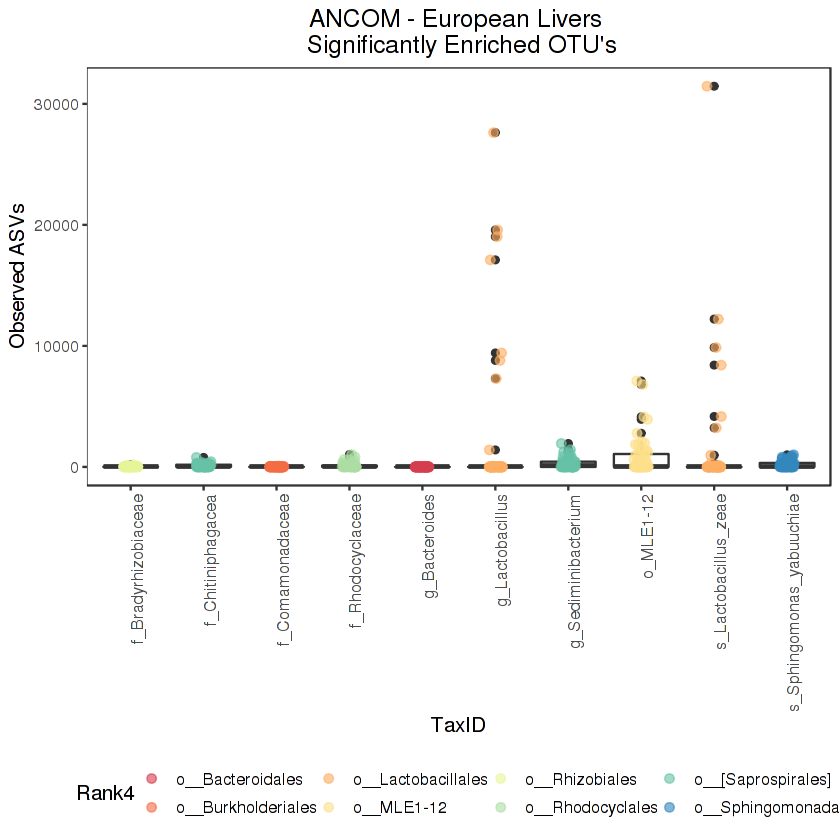

In [88]:
p = ggplot(liver_data, aes(x = TaxID, y = Abundance)) + ggtitle("ANCOM - European Livers \n Significantly Enriched OTU's")

p = p + geom_boxplot() + ylab("Observed ASVs")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,50))

p = p + geom_point(size = 2,alpha=.6, aes(color = Rank4),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

#p = p + facet_wrap(~Organ, ncol=2)

p

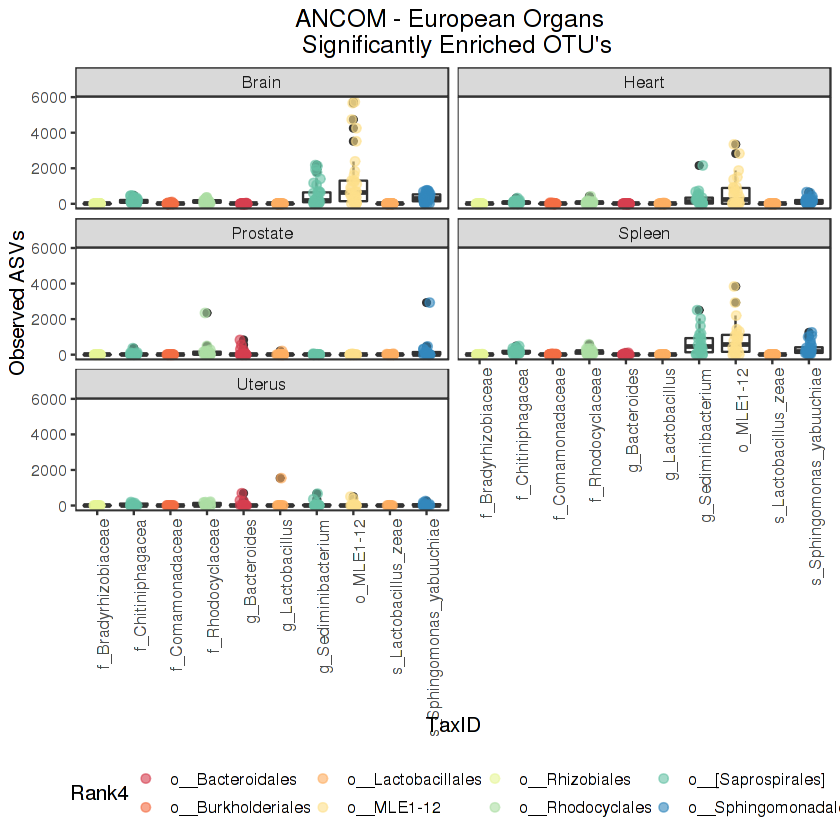

In [90]:
p = ggplot(other_data, aes(x = TaxID, y = Abundance)) + ggtitle("ANCOM - European Organs \n Significantly Enriched OTU's")

p = p + geom_boxplot() + ylab("Observed ASVs")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,50))

p = p + geom_point(size = 2,alpha=.6, aes(color = Rank4),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p = p + facet_wrap(~Organ, ncol=2)

p

### USA Organs - covariates: Sex, Age, PMI

In [57]:
#READ IN DATA

USA_otu = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/USA_otu.csv")
USA_meta = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/USA_meta.csv")

names(USA_otu)[1]<-"Sample.ID"
names(USA_meta)[1]<-"Sample.ID"

In [59]:
#RUN ANCOM

comparison_test=ANCOM.main(OTUdat=USA_otu,
                           Vardat=USA_meta,
                           adjusted=TRUE,
                           repeated=F,
                           main.var="Organ",
                           adj.formula="Sex+Age+PMI", #covariates
                           repeat.var=NULL,
                           longitudinal=FALSE,
                           random.formula=NULL,
                           multcorr=2, #2 corresponds to BH FDR correction
                           sig=0.05,
                           prev.cut=0.90)

USA_Org_by_sex_age_PMI.ancom = comparison_test$W.taxa
head(USA_Org_by_sex_age_PMI.ancom)

,otu.names,W_stat,detected_0.9,detected_0.8,detected_0.7,detected_0.6
95,TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGATTCTTAAGTCAGAGGTGAAATCCCAGGGCTCAACCCTGGAACTGCCTTTGATACTGGGGATCTCGAGTTCGAGAGAGGTGAGTGGAACTGCGAG,176,TRUE,TRUE,TRUE,TRUE
37,TACGTAGGGGGCTAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGCCAGAAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTTTTGGAACTGTAGGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGT,174,TRUE,TRUE,TRUE,TRUE
100,TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACTGACTAGAGTATGGTAGAGGGTGGTGGAATTTCCTG,172,TRUE,TRUE,TRUE,TRUE
104,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGG,171,TRUE,TRUE,TRUE,TRUE
32,TACGTAGGTGGCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCATGCGTAGGCGGATACTTAAGTGGGATGTGAAATCCCGGGGCTCAACCCCGGTGCTGCATTCCAAACTGGGTATCTAGAGTACAGGAGAGGAAAGCGGAATTCCTAG,151,FALSE,TRUE,TRUE,TRUE
132,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,139,FALSE,FALSE,TRUE,TRUE


In [91]:
USA_Org_by_sex_age_PMI.ancom = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/USA_Org_by_sexagelocPMI.ancom.csv")

In [62]:
tax_table = read.csv("/group/gilbert-lab/Lutz/Cadaver/tax_table.csv")

In [ ]:
sig_taxa <- left_join(USA_Org_by_sex_age_PMI.ancom, tax_table)
write.csv(sig_taxa, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/ANCOM/USA_Org_by_sexlocPMIloc.ancom.sigres.taxa.csv")

In [ ]:
'TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGATTCTTAAGTCAGAGGTGAAATCCCAGGGCTCAACCCTGGAACTGCCTTTGATACTGGGGATCTCGAGTTCGAGAGAGGTGAGTGGAACTGCGAG',
'TACGTAGGGGGCTAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGCCAGAAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTTTTGGAACTGTAGGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGT',
'TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACTGACTAGAGTATGGTAGAGGGTGGTGGAATTTCCTG',
'TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGG',
'TACGTAGGTGGCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCATGCGTAGGCGGATACTTAAGTGGGATGTGAAATCCCGGGGCTCAACCCCGGTGCTGCATTCCAAACTGGGTATCTAGAGTACAGGAGAGGAAAGCGGAATTCCTAG',
'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG',
'TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTGGTCGCGTCTGCTGTGAAAGGCTGGGGCTTAACCCTGGTTTTGCAGTGGGTACGGGCTAACTAGAGTGCAGTAGGGGAGACTGGAATTCCTGG',
'TACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCGTTGGAAACTGTATAACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGT',
'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAG'

In [96]:
### Subset OTUs ID'd by ANCOM


subset <- subset(otu_table(cadaver_nt), 
        rownames(otu_table(cadaver_nt)) %in% c('TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGATTCTTAAGTCAGAGGTGAAATCCCAGGGCTCAACCCTGGAACTGCCTTTGATACTGGGGATCTCGAGTTCGAGAGAGGTGAGTGGAACTGCGAG',
'TACGTAGGGGGCTAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTCAAGCCAGAAGTGAAAGGCTACGGCTCAACCGTAGTAAGCTTTTGGAACTGTAGGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGT',
'TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACTGACTAGAGTATGGTAGAGGGTGGTGGAATTTCCTG',
'TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCCAGG',
'TACGTAGGTGGCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCATGCGTAGGCGGATACTTAAGTGGGATGTGAAATCCCGGGGCTCAACCCCGGTGCTGCATTCCAAACTGGGTATCTAGAGTACAGGAGAGGAAAGCGGAATTCCTAG',
'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG',
'TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTGGTCGCGTCTGCTGTGAAAGGCTGGGGCTTAACCCTGGTTTTGCAGTGGGTACGGGCTAACTAGAGTGCAGTAGGGGAGACTGGAATTCCTGG',
'TACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCGTTGGAAACTGTATAACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGT',
'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAG')
)
merged <- merge_phyloseq(subset, tax_table(cadaver_nt), sample_data(cadaver_nt))

In [97]:
data = psmelt(merged)
data$Location = as.character(data$Location)
data1 <- data[which(data$Location=='USA'),]
data1$Location = as.factor(data1$Location)
head(data1$Location)
write.csv(data1, "/group/gilbert-lab/Lutz/Cadaver/temp_data.csv")

[1] USA USA USA USA USA USA
Levels: USA

In [99]:
data1 = read.csv("/group/gilbert-lab/Lutz/Cadaver/temp_data.csv")

In [100]:
stats = data1 %>%
    group_by(Organ, TaxID) %>%
    summarize(median = median(Abundance), 
              mean = mean(Abundance),
              sd = sd(Abundance),
              sem = sd(Abundance/sqrt(length(Abundance))))
head(stats)

Organ,TaxID,median,mean,sd,sem
Blood,f_Peptostreptococcaceae,295,2643.857143,4579.210865,1730.779021
Blood,g_Bacteroides,0,10.142857,17.382257,6.569876
Blood,g_Blautias,0,4.428571,11.716899,4.428571
Blood,g_Clostridium,0,1056.142857,2780.632448,1050.980278
Blood,g_Fusobacterium,1,3.428571,5.191568,1.962228
Blood,g_Pseudomonas,55,565.142857,1308.205696,494.455276


In [102]:
liver_data <- data1[which(data1$Organ=='Liver'),]
other_data <- data1[which(data1$Organ!='Liver'),]

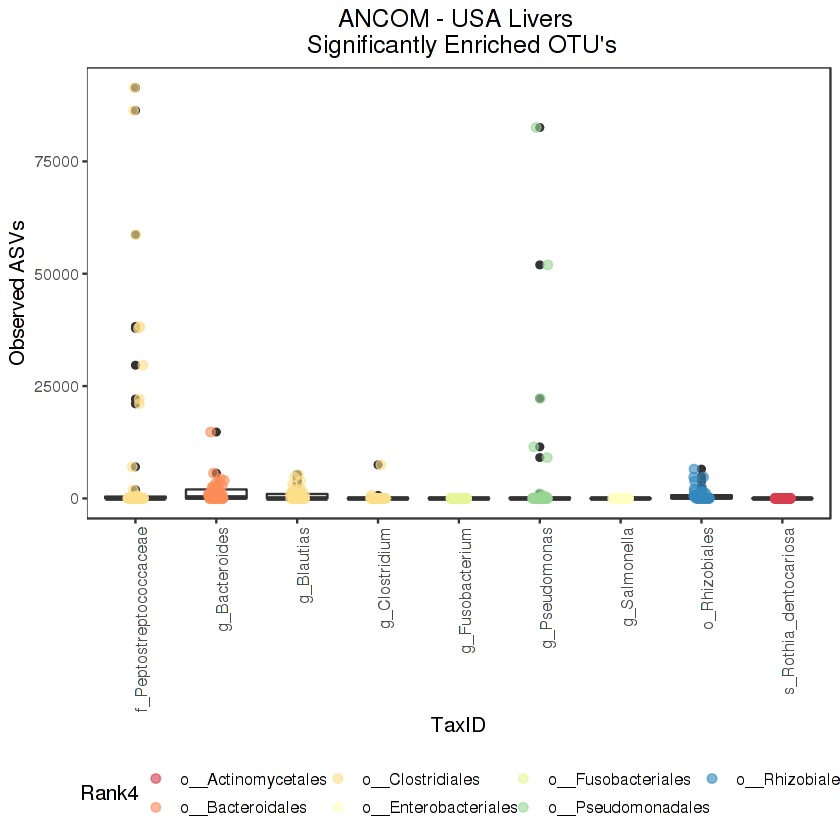

In [103]:
p = ggplot(liver_data, aes(x = TaxID, y = Abundance)) + ggtitle("ANCOM - USA Livers \n Significantly Enriched OTU's")

p = p + geom_boxplot() + ylab("Observed ASVs")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,50))

p = p + geom_point(size = 2,alpha=.6, aes(color = Rank4),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

#p = p + facet_wrap(~Organ, ncol=2)

p

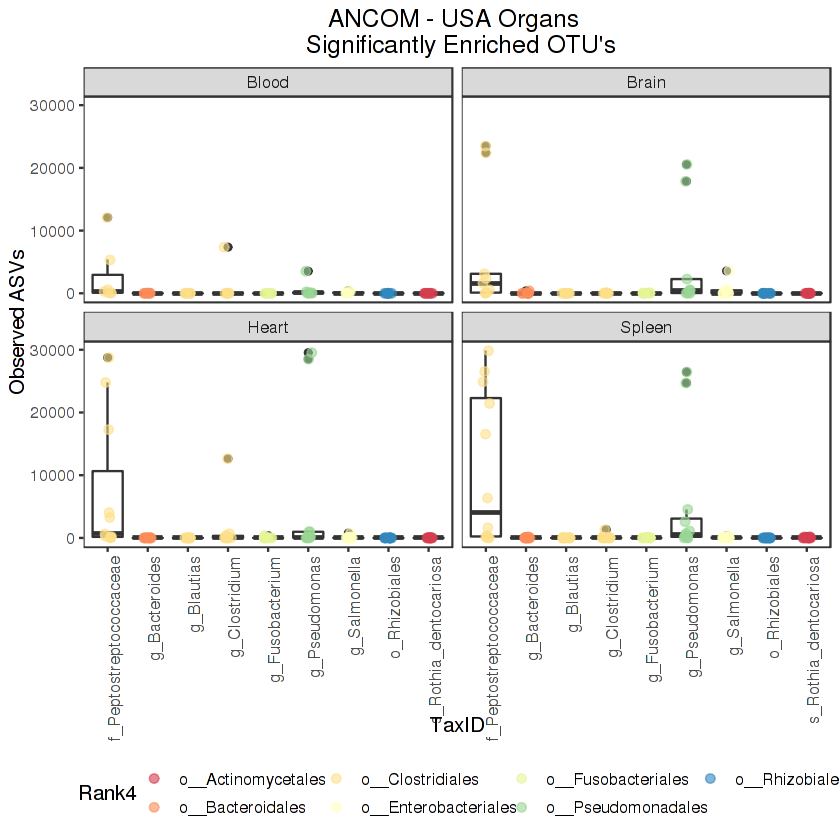

In [104]:
p = ggplot(other_data, aes(x = TaxID, y = Abundance)) + ggtitle("ANCOM - USA Organs \n Significantly Enriched OTU's")

p = p + geom_boxplot() + ylab("Observed ASVs")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,50))

p = p + geom_point(size = 2,alpha=.6, aes(color = Rank4),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p = p + facet_wrap(~Organ, ncol=2)

p

### DESeq of Piphillin

In [127]:
counts <- as.matrix(read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/PIPHILLIN/Euro_US_liver/merged_liver.csv", check.names = FALSE, row.names=1))
map <- read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/map_files/all_cadaver_metadata_liver.csv", row.names=1)
ncol(counts)
nrow(map)
head(counts)
head(map)
all(rownames(map) %in% colnames(counts))


[1] 80

[1] 80

,3813.13Liver,3813.16Liver,3813.26Liver,3813.31Liver,3813.36Liver,3813.3Liver,3813.46Liver,3813.52Liver,3813.8Liver,4522.C15Liver,...,Case35Liver,Case37Liver,Case40Liver,Case4Liver,Case50Liver,Case5Liver,Case72Liver,Case95Liver,Case98Liver,Case99Liver
ko00010,42851,28922,64,24261,29141,1032,29532,988,10616,40412,...,33832,21642,33021,40132,23746,10815,23045,9056,37232,17611
ko00020,26274,23444,31,6376,24106,754,23144,676,5630,23672,...,8873,4895,14932,31442,9168,7911,17461,6993,22368,12790
ko00030,29115,26867,47,12232,27435,772,26820,786,8201,27189,...,20851,13193,22196,28907,14925,7278,16340,6379,24646,12156
ko00040,17256,8195,26,2978,8322,338,8535,299,2617,16137,...,9749,6118,13563,13211,6967,3731,7230,2587,11502,5979
ko00051,35341,18317,60,13990,18311,617,18879,607,6794,33828,...,20773,12133,23920,18318,13124,4892,10386,4228,23555,7713
ko00052,40283,7084,36,12355,6685,448,7695,407,5827,36964,...,17632,12306,18386,15814,10798,4416,8874,3232,16176,7123


,BarcodeSequence,LinkerPrimerSequence,RTL_run,Case_no,Sex,Age,Ethnicity,Order,Nation,Location,...,Organ,RTLID,Samplename,Cause_of_death,The_manner_of_death,Height_cm,Weight_kg,bmi,bmi_category,Description
3813.13Liver,AAAACACA,GTGCCAGCMGCCGCGGTAA,3813,C15,F,40,C,3813,USA,USA,...,Liver,13,13-MS515F,Bowel Obstruction,Natural,165,55,20.20,normal,3813.13_Liver
3813.16Liver,AAAACACT,GTGCCAGCMGCCGCGGTAA,3813,C18,F,28,L,3813,USA,USA,...,Liver,16,16-MS515F,Car Accident,Accident,162,73,27.82,overweight,3813.16_Liver
3813.26Liver,AAAACCAG,GTGCCAGCMGCCGCGGTAA,3813,C29,M,48,C,3813,USA,USA,...,Liver,26,26-MS515F,Overdose,Accident,183,83,24.78,normal,3813.26_Liver
3813.31Liver,AAAACCGA,GTGCCAGCMGCCGCGGTAA,3813,C32,M,45,A,3813,USA,USA,...,Liver,31,31-MS515F,Gunshot wound,Homicide,178,117,36.93,obese,3813.31_Liver
3813.36Liver,AAAACCTC,GTGCCAGCMGCCGCGGTAA,3813,C38,F,50,C,3813,USA,USA,...,Liver,36,36-MS515F,Overdose,Accident,174,48,15.85,underweight,3813.36_Liver
3813.3Liver,AAAACCCG,GTGCCAGCMGCCGCGGTAA,3813,C1,M,51,C,3813,USA,USA,...,Liver,3,3-MS515F,Coronary Heart Disease,Natural,180,82,25.31,overweight,3813.3_Liver


[1] TRUE

In [128]:
all(rownames(map) == colnames(counts))



[1] TRUE

In [130]:
library("DESeq2")

liver_nation_dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = map,
                              design = ~Nation)
liver_nation_dds

class: DESeqDataSet 
dim: 285 80 
metadata(1): version
assays(1): counts
rownames(285): ko00010 ko00020 ... ko05416 ko05418
rowData names(0):
colnames(80): 3813.13Liver 3813.16Liver ... Case98Liver Case99Liver
colData names(21): BarcodeSequence LinkerPrimerSequence ...
  bmi_category Description

In [131]:
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(liver_nation_dds), 1, gm_mean)


liver_nation_dds = estimateSizeFactors(liver_nation_dds, geoMeans = geoMeans)
liver_nation_dds = estimateDispersions(liver_nation_dds)
abund = getVarianceStabilizedData(liver_nation_dds)

liver_nation_dds = DESeq(liver_nation_dds, test="Wald", fitType="parametric")

res = results(liver_nation_dds)

alpha = 0.05
sigtab = res[which(res$padj < alpha), ]

head(sigtab)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


log2 fold change (MLE): Nation USA vs Europe 
Wald test p-value: Nation USA vs Europe 
DataFrame with 6 rows and 6 columns
           baseMean log2FoldChange      lfcSE      stat       pvalue
          <numeric>      <numeric>  <numeric> <numeric>    <numeric>
ko00072 1480.994419     -0.6221409 0.20640021 -3.014245 2.576194e-03
ko00100    7.602852      3.3168424 0.93072821  3.563707 3.656544e-04
ko00130 3531.931867     -0.6998606 0.16396677 -4.268307 1.969618e-05
ko00232    1.447457      4.7769009 1.26907082  3.764093 1.671545e-04
ko00261 3135.095363      0.1431943 0.06023002  2.377456 1.743251e-02
ko00290 5326.712906      0.2287038 0.06902726  3.313238 9.222231e-04
                padj
           <numeric>
ko00072 0.0082496098
ko00100 0.0018818880
ko00130 0.0001810778
ko00232 0.0011041556
ko00261 0.0439669381
ko00290 0.0033696612

In [132]:
write.csv(sigtab, file="/group/gilbert-lab/Lutz/Cadaver/All_cohorts/PIPHILLIN/Euro_US_liver/liver_nation_dds.sigres.csv")


In [141]:
library("DESeq2")

liver_sex_dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = map,
                              design = ~Sex)
liver_sex_dds

class: DESeqDataSet 
dim: 285 80 
metadata(1): version
assays(1): counts
rownames(285): ko00010 ko00020 ... ko05416 ko05418
rowData names(0):
colnames(80): 3813.13Liver 3813.16Liver ... Case98Liver Case99Liver
colData names(21): BarcodeSequence LinkerPrimerSequence ...
  bmi_category Description

In [142]:
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(liver_sex_dds), 1, gm_mean)


liver_sex_dds = estimateSizeFactors(liver_sex_dds, geoMeans = geoMeans)
liver_sex_dds = estimateDispersions(liver_sex_dds)
abund = getVarianceStabilizedData(liver_sex_dds)

liver_sex_dds = DESeq(liver_sex_dds, test="Wald", fitType="parametric")

res = results(liver_sex_dds)

alpha = 0.05
sigtab = res[which(res$padj < alpha), ]

head(sigtab)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 11 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


log2 fold change (MLE): Sex M vs F 
Wald test p-value: Sex M vs F 
DataFrame with 0 rows and 6 columns

In [143]:
write.csv(sigtab, file="/group/gilbert-lab/Lutz/Cadaver/All_cohorts/PIPHILLIN/Euro_US_liver/liver_sex_dds.sigres.csv")
